In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import torchvision.models as models
import librosa
import warnings
import random
import numpy as np
import pandas as pd
from torchaudio import transforms as audio_transforms
from torch import optim
from IPython.display import Audio, display
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms as vision_transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, binarize
from tqdm.notebook import tqdm
from PIL import Image, ImageDraw
from typing import List, Dict, Tuple, Union
from sklearn.metrics import (roc_auc_score, 
                             mean_squared_error, 
                             precision_score, 
                             recall_score, 
                             accuracy_score, 
                             balanced_accuracy_score, 
                             f1_score, roc_curve)

warnings.filterwarnings('ignore')

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

print(torch.__version__)
print(torchaudio.__version__)

1.9.0+cu102
0.9.0


In [2]:
def open(audio_file):
    y, sr = torchaudio.load(audio_file)
    return (y, sr)

def spectrogram(aud, n_mels=64, n_fft=1024, hop_len=None):
    sig, sr = aud
    top_db = 8
    
    spec = audio_transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)
    spec = audio_transforms.AmplitudeToDB(top_db=top_db)(spec)
    
    return spec

def getMetrics(Y_files_test, files_preds, output=True, threshold=0.5) -> Tuple:
    rms = np.sqrt(mean_squared_error(Y_files_test, files_preds))
    precision = precision_score(Y_files_test,  binarize(files_preds.reshape(-1, 1), threshold=threshold))
    recall = recall_score(Y_files_test,  binarize(files_preds.reshape(-1, 1), threshold=threshold))
    accuracy = accuracy_score(Y_files_test,  binarize(files_preds.reshape(-1, 1), threshold=threshold))
    balanced_accuracy = balanced_accuracy_score(Y_files_test,  binarize(files_preds.reshape(-1, 1), threshold=threshold))
    f1 = f1_score(Y_files_test,  binarize(files_preds.reshape(-1, 1), threshold=threshold))
    f1_weighted = f1_score(Y_files_test,  binarize(files_preds.reshape(-1, 1), threshold=threshold), average = 'weighted')
    auc_roc = roc_auc_score(Y_files_test,  files_preds)
    if output:
        print(f"RMS: {rms}\n"
              f"Precision score: {precision}\n"
              f"Recall score: {recall}\n"
              f"Accuracy score: {accuracy}\n"
              f"Balanced accuracy score: {balanced_accuracy}\n"
              f"F1 score: {f1}\n"
              f"F1 weighted score: {f1_weighted}\n"
              f"AUC-ROC score: {auc_roc}")
    return (rms, precision, recall, accuracy, balanced_accuracy, f1, f1_weighted, auc_roc)

In [3]:
df = pd.read_csv('/home/latna/aponom/whales/Canada/data/clips/dataset_B/train/annotations_B_train.csv', sep=';')

display(df.sample(10))
display(df.describe())

,clip_name,label,snr
52,B_61.wav,0,4.50
680,B_801.wav,1,9.99
1376,B_1621.wav,1,9.50
1237,B_1463.wav,1,12.65
203,B_243.wav,0,5.90
2973,B_3493.wav,0,11.99
1323,B_1564.wav,0,7.20
2418,B_2835.wav,1,8.55
1671,B_1969.wav,1,13.45
485,B_573.wav,1,6.27


,label,snr
count,3309.000000,3309.000000
mean,0.614385,9.460719
std,0.486814,5.018798
min,0.000000,-6.040000
25%,0.000000,5.960000
50%,1.000000,8.580000
75%,1.000000,12.080000
max,1.000000,42.270000


In [4]:
display(df.drop(["label"], axis=1))
display(df["label"])

,clip_name,snr
0,B_0.wav,-1.91
1,B_1.wav,7.01
2,B_2.wav,13.80
3,B_3.wav,8.42
4,B_5.wav,14.45
...,...,...
3304,B_3886.wav,12.38
3305,B_3887.wav,6.58
3306,B_3888.wav,18.81
3307,B_3889.wav,16.99


0       0
1       0
2       0
3       0
4       0
       ..
3304    0
3305    0
3306    1
3307    1
3308    1
Name: label, Length: 3309, dtype: int64

In [5]:
display(df.iloc[122]["clip_name"])

'B_146.wav'

In [6]:
import matplotlib
import matplotlib.pyplot as plt

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
        axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
        axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)

1) Waveform: tensor([[-2.4414e-04, -5.1880e-04, -1.2207e-04,  ..., -1.5259e-04,
         -3.0518e-05, -2.1362e-04]])
Sample rate: 1000
Size = torch.Size([1, 3001])
Mel-Spectrogram as tensor: tensor([[[2.8422e-03, 2.0674e-03, 1.5007e-03,  ..., 2.0326e-03,
          1.4276e-03, 3.7046e-03],
         [7.2302e-04, 3.2346e-04, 3.4173e-04,  ..., 7.9465e-04,
          6.4378e-04, 3.7770e-04],
         [2.6112e-04, 4.0646e-04, 1.4496e-04,  ..., 3.8910e-04,
          6.3023e-04, 5.0411e-04],
         ...,
         [1.5200e-06, 3.8461e-06, 7.7210e-06,  ..., 4.6232e-06,
          1.5324e-06, 2.4866e-06],
         [1.2758e-05, 4.2711e-06, 5.2648e-06,  ..., 1.5313e-06,
          3.3643e-06, 7.2634e-06],
         [6.2126e-05, 7.5878e-06, 1.7487e-05,  ..., 4.6280e-06,
          2.5490e-06, 6.9033e-07]]]), shape: torch.Size([1, 128, 16])


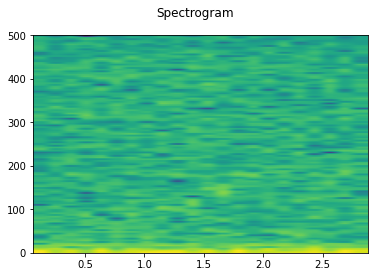

2) Waveform: tensor([[ 0.0025,  0.0046,  0.0038,  ..., -0.0040, -0.0039, -0.0015]])
Sample rate: 1000
Size = torch.Size([1, 3001])
Mel-Spectrogram as tensor: tensor([[[1.8471e-01, 3.1597e-01, 2.2504e-01,  ..., 1.7193e-02,
          8.3780e-02, 1.8489e-02],
         [2.7968e-01, 1.5377e-01, 1.2066e-01,  ..., 1.2237e-02,
          4.0462e-02, 6.3083e-02],
         [4.4061e-02, 6.0046e-03, 1.3391e-02,  ..., 1.9181e-03,
          5.8632e-03, 5.8559e-02],
         ...,
         [2.1628e-05, 1.1455e-05, 3.8485e-05,  ..., 7.9460e-05,
          9.1271e-05, 5.8964e-05],
         [5.7642e-05, 1.4065e-05, 3.4753e-05,  ..., 3.5620e-05,
          1.3292e-04, 9.8480e-05],
         [1.7750e-04, 5.8215e-05, 8.5823e-05,  ..., 5.0853e-05,
          2.7065e-05, 5.6795e-05]]]), shape: torch.Size([1, 128, 16])


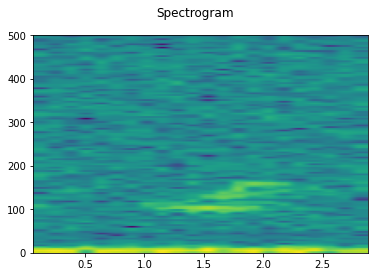

3) Waveform: tensor([[0.0006, 0.0009, 0.0009,  ..., 0.0033, 0.0036, 0.0012]])
Sample rate: 1000
Size = torch.Size([1, 3001])
Mel-Spectrogram as tensor: tensor([[[8.2668e-03, 7.4008e-03, 5.3712e-02,  ..., 1.5516e-02,
          2.4778e-02, 3.0497e-02],
         [2.7589e-03, 1.6812e-02, 1.0581e-01,  ..., 8.9548e-02,
          7.7830e-02, 7.6583e-02],
         [1.4679e-02, 1.4778e-02, 6.5407e-02,  ..., 1.0449e-01,
          5.0713e-02, 4.4643e-02],
         ...,
         [2.3007e-04, 4.7810e-06, 2.6451e-05,  ..., 1.4774e-05,
          5.3826e-06, 1.7733e-04],
         [4.8021e-05, 2.0513e-05, 1.9910e-05,  ..., 1.7165e-05,
          1.0291e-05, 7.4035e-05],
         [9.8339e-05, 7.8367e-05, 1.6417e-05,  ..., 1.9696e-05,
          4.2199e-06, 1.0964e-05]]]), shape: torch.Size([1, 128, 16])


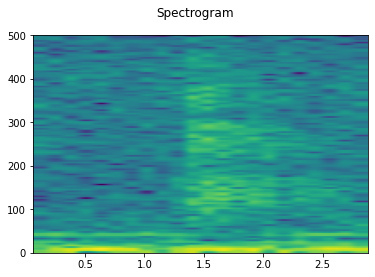

In [7]:
for i in range(3):
    waveform, sample_rate = open('/home/latna/aponom/whales/Canada/data/clips/dataset_B/train/audio/' + df['clip_name'][random.randint(1, 1000)])
    mel_spectrogram = audio_transforms.MelSpectrogram(sample_rate)(waveform)
    print(f"{i+1}) Waveform: {waveform}\nSample rate: {sample_rate}\nSize = {waveform.shape}")
    print(f"Mel-Spectrogram as tensor: {mel_spectrogram}, shape: {mel_spectrogram.shape}")
    plot_specgram(waveform, sample_rate)

In [8]:
class AudioDataset(Dataset):
    def __init__(self, dataframe, audio_path):
        self.df = dataframe
        self.files_path = audio_path

    def __len__(self):
        return len(self.df)    

    def __getitem__(self, idx):

        waveform, sample_rate = torchaudio.load(self.files_path + self.df['clip_name'][idx])
        
        mel_spectrogram = audio_transforms.MelSpectrogram(sample_rate, normalized=True)(waveform)
        mel_spectrogram = mel_spectrogram.repeat(3, 1, 1)
        mel_spectrogram = np.transpose(mel_spectrogram.numpy(), (1,2,0))
        mel_spectrogram = np.transpose(mel_spectrogram,(2,0,1)).astype(np.float32)

        label = self.df['label'][idx]
        
        return torch.tensor(mel_spectrogram, dtype = torch.float), torch.tensor(label, dtype = torch.float)

In [9]:
df = pd.read_csv('/home/latna/aponom/whales/Canada/data/clips/dataset_A/train/annotations_A_train.csv', sep=';')

WhalesDataset = AudioDataset(df, "/home/latna/aponom/whales/Canada/data/clips/dataset_A/train/audio/")

In [9]:
device = ("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cpu


In [10]:
import random

indexes = list(range(0, len(WhalesDataset)))

train_index = indexes[:round(0.8 * len(WhalesDataset))]
test_index = indexes[round(0.8 * len(WhalesDataset)):]

train = AudioDataset(df.iloc[train_index], "/home/latna/aponom/whales/Canada/data/clips/dataset_A/train/audio/")
test = AudioDataset(df.iloc[test_index].reset_index(), "/home/latna/aponom/whales/Canada/data/clips/dataset_A/train/audio/")

display(len(train))
display(len(test))

NameError: name 'WhalesDataset' is not defined

In [13]:
train_loader = DataLoader(train, shuffle=True)
test_loader = DataLoader(test, shuffle=False)

In [11]:
class CNN1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(6, 2), padding=(3, 2))
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(6, 2), padding=(3, 2))
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(6, 2), padding=(3, 2))
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(6, 2), padding=(3, 2))
        self.bn4 = nn.BatchNorm2d(256)
        
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(6, 2), padding=(3, 2))
        self.bn5 = nn.BatchNorm2d(512)
        
        self.maxpool = nn.MaxPool2d(kernel_size=(4, 2), stride=(2, 2))
        self.avg = nn.AvgPool2d((2, 3))
        self.dropout = nn.Dropout(0.5)
        
        self.fc = nn.Linear(512, 1)
        
    def forward(self, x):
        x = self.dropout(self.maxpool(F.leaky_relu(self.bn1(self.conv1(x)))))
        x = self.dropout(self.maxpool(F.leaky_relu(self.bn2(self.conv2(x)))))
        x = self.dropout(self.maxpool(F.leaky_relu(self.bn3(self.conv3(x)))))
        x = self.dropout(self.maxpool(F.leaky_relu(self.bn4(self.conv4(x)))))
        x = self.dropout(self.maxpool(F.leaky_relu(self.bn5(self.conv5(x)))))
        x = self.avg(x)
        x = x.view(-1, 512)
        x = self.fc(x)
        return x

In [15]:
model_1 = CNN1()
learning_rate = 0.01
device = ("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_1.parameters(), lr=learning_rate)
epochs = 20

In [12]:
def train(model,
          model_name,
          epochs, 
          train_loader, 
          test_loader, 
          criterion, 
          optimizer):

    train_loss_history = np.empty(0)
    train_roc_auc_history = np.empty(0)
    test_loss_history = np.empty(0)
    test_roc_auc_history = np.empty(0)
    best_roc_auc = 0.5
    iterations_per_train_epoch = len(train_loader)
    test_final_predictions = torch.empty(0, device=device)

    model.train()
    for epoch in range(epochs):
        train_preds = torch.empty(0, device=device)
        train_labels = torch.empty(0, device=device)
        for data, label in tqdm(train_loader, total=iterations_per_train_epoch):
            data, label = data.to(device).float(), label.to(device).float()
            optimizer.zero_grad()
            preds = torch.as_tensor(model(data)[0])
            loss = criterion(preds, label)
            loss.backward()
            optimizer.step()
            train_preds = torch.cat((train_preds, preds))
            train_labels = torch.cat((train_labels, label))

        train_preds = torch.squeeze(train_preds)
        train_labels = torch.squeeze(train_labels)

        loss = criterion(train_preds, train_labels)
        roc_auc = roc_auc_score(train_labels.cpu().detach().numpy(), train_preds.cpu().detach().numpy())
        train_loss_history = np.append(train_loss_history, loss.cpu().detach().numpy())
        train_roc_auc_history = np.append(train_roc_auc_history, roc_auc)
        print(f"Epoch: {epoch + 1}\nTrain Loss = {loss}, Train ROC-AUC = {roc_auc}")

        with torch.no_grad():
            test_preds = torch.empty(0, device=device)
            test_labels = torch.empty(0, device=device)
            for data, label in test_loader:
                data, label = data.to(device).float(), label.to(device).float()
                preds = torch.as_tensor(model(data)[0])
                loss = criterion(preds, label)
                test_preds = torch.cat((test_preds, preds))
                test_labels = torch.cat((test_labels, label))

            test_preds = torch.squeeze(test_preds)
            test_labels = torch.squeeze(test_labels)

            loss = criterion(test_preds, test_labels)
            roc_auc = roc_auc_score(test_labels.cpu().detach().numpy(), test_preds.cpu().detach().numpy())
            test_loss_history = np.append(test_loss_history, loss.cpu().detach().numpy())
            test_roc_auc_history = np.append(test_roc_auc_history, roc_auc)

            print(f"Test Loss = {loss}, Test ROC-AUC = {roc_auc}")

            if roc_auc > best_roc_auc:
                torch.save(model.state_dict(), "best_roc_auc_" + model_name + ".pth")
                print("Model saved successfully\n")
                best_roc_auc = roc_auc
                test_final_predictions = test_preds
            else:
                print()

    torch.save(model.state_dict(), "final_" + model_name + ".pth")
    model.eval()
    
    return (model, 
            test_final_predictions, 
            train_loss_history, 
            train_roc_auc_history, 
            test_loss_history, 
            test_roc_auc_history, 
            best_roc_auc)

In [17]:
%%time
(model_1, 
test_final_predictions, 
train_loss_history, 
train_roc_auc_history, 
test_loss_history, 
test_roc_auc_history, 
best_roc_auc) = train(model_1, epochs, train_loader, test_loader, criterion, optimizer)

TypeError: train() missing 1 required positional argument: 'optimizer'

In [13]:
def process_predictions(predictions: np.array, threshold: float) -> np.array:
    new_predictions = predictions.copy()
    for i in range(len(predictions)):
        new_predictions[i] = 1.0 if new_predictions[i] > threshold else 0.0
    return new_predictions

def find_best_threshold(labels: np.array, predictions: np.array) -> (np.array, float, float):
    best_threshold, best_roc_auc = 0, 0
    best_predictions = predictions.copy()
    for threshold in np.linspace(0.01, 0.99, 30):
        current_predictions = process_predictions(predictions, threshold)
        current_roc_auc = roc_auc_score(labels, current_predictions)
        if current_roc_auc > best_roc_auc:
            best_roc_auc = current_roc_auc
            best_threshold = threshold
            best_predictions = current_predictions
    return best_predictions, best_threshold, best_roc_auc

In [271]:
test_labels = torch.empty(0, device=device)
for data, label in test_loader:
    test_labels = torch.cat((test_labels, label))
test_labels = torch.squeeze(test_labels)

In [14]:
def plot_loss_changing(train_loss_history: np.array, test_loss_history: np.array) -> None:
    train_loss_idx = list(range(0, len(train_loss_history)))
    test_loss_idx = list(range(0, len(test_loss_history)))

    plt.plot(train_loss_idx, train_loss_history, label="train_loss")
    plt.plot(test_loss_idx, test_loss_history, label="test_loss")

    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.title("Loss changing")

    plt.legend()
    plt.show()

In [15]:
def plot_roc_auc_changing(train_roc_auc_history: np.array, test_roc_auc_history: np.array) -> None:
    train_roc_auc_idx = list(range(0, len(train_roc_auc_history)))
    test_roc_auc_idx = list(range(0, len(test_roc_auc_history)))

    plt.plot(train_roc_auc_idx, train_roc_auc_history, label="train_roc_auc")
    plt.plot(test_roc_auc_idx, test_roc_auc_history, label="test_roc_auc")

    plt.xlabel("Epoch")
    plt.ylabel("ROC-AUC")

    plt.title("ROC-AUC changing")

    plt.legend()
    plt.show()

In [16]:
def plot_roc_auc(Y_true: np.array, Y_predicted: np.array):
    constant_negative = [0 for _ in range(len(Y_true))]
    constant_negative_auc = roc_auc_score(Y_true, constant_negative)
    prediction_results_auc = roc_auc_score(Y_true, Y_predicted)
    constant_negative_fpr, constant_negative_tpr, _ = roc_curve(Y_true, constant_negative)
    prediction_results_fpr, prediction_results_tpr, _ = roc_curve(Y_true, Y_predicted)
    plt.plot(constant_negative_fpr, constant_negative_tpr, linestyle='--', label='Constant negative')
    plt.plot(prediction_results_fpr, prediction_results_tpr, marker='.', label='Logistic')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

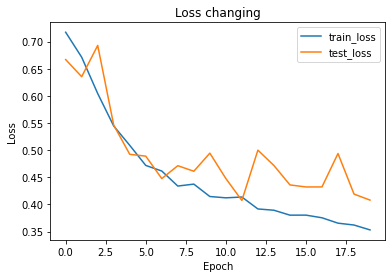

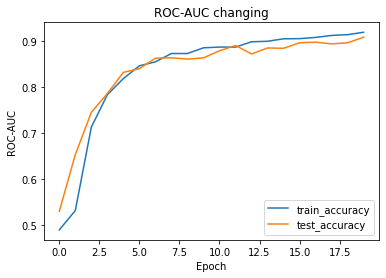

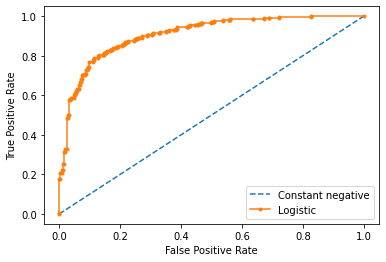

RMS: 2.8955934047698975
Precision score: 0.8449074074074074
Recall score: 0.8924205378973105
Accuracy score: 0.8323262839879154
Balanced accuracy score: 0.8137992017549793
F1 score: 0.868014268727705
F1 weighted score: 0.8306268561431633
AUC-ROC score: 0.9086946857755831


In [275]:
plot_loss_changing(train_loss_history, test_loss_history)
plot_roc_auc_changing(train_roc_auc_history, test_roc_auc_history)
plot_roc_auc(test_labels.cpu().detach().numpy(), test_final_predictions)

cnn1_metrics = getMetrics(test_labels, test_final_predictions)

In [17]:
class CNN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(6, 2), padding=(3, 2))
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(6, 2), padding=(3, 2))
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(6, 2), padding=(3, 2))
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(6, 2), padding=(3, 2))
        self.bn4 = nn.BatchNorm2d(256)
        
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(6, 2), padding=(3, 2))
        self.bn5 = nn.BatchNorm2d(512)
        
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=(6, 2), padding=(3, 2))
        self.bn6 = nn.BatchNorm2d(1024)
        
        self.conv7 = nn.Conv2d(in_channels=1024, out_channels=2048, kernel_size=(6, 2), padding=(3, 2))
        self.bn7 = nn.BatchNorm2d(2048)
        
        self.maxpool = nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 2))
        self.avg = nn.AvgPool2d((1, 2))
        self.dropout = nn.Dropout(0.65)
        
        self.fc = nn.Linear(2048, 1)
        
    def forward(self, x):
        x = self.dropout(self.maxpool(F.leaky_relu(self.bn1(self.conv1(x)))))
        x = self.dropout(self.maxpool(F.leaky_relu(self.bn2(self.conv2(x)))))
        x = self.dropout(self.maxpool(F.leaky_relu(self.bn3(self.conv3(x)))))
        x = self.dropout(self.maxpool(F.leaky_relu(self.bn4(self.conv4(x)))))
        x = self.dropout(self.maxpool(F.leaky_relu(self.bn5(self.conv5(x)))))
        x = self.dropout(self.maxpool(F.leaky_relu(self.bn6(self.conv6(x)))))
        x = self.dropout(self.maxpool(F.leaky_relu(self.bn7(self.conv7(x)))))
        x = self.avg(x)
        x = x.view(-1, 2048)
        x = self.fc(x)
        return x

In [240]:
model_2 = CNN2()
learning_rate = 0.01
device = ("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_1.parameters(), lr=learning_rate)
epochs = 20

In [241]:
%%time
(model_2, 
test_final_predictions, 
train_loss_history, 
train_roc_auc_history, 
test_loss_history, 
test_roc_auc_history, 
best_roc_auc) = train(model_2, epochs, train_loader, test_loader, criterion, optimizer)

  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 1
Train Loss = 0.7335453629493713, Train ROC-AUC = 0.4858020983625507
Test Loss = 0.7185002565383911, Test ROC-AUC = 0.5109989648033126
Model saved successfully



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 2
Train Loss = 0.7195058465003967, Train ROC-AUC = 0.5333692486474995
Test Loss = 0.7297480702400208, Test ROC-AUC = 0.47107919254658387



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 3
Train Loss = 0.7292754054069519, Train ROC-AUC = 0.49460341443176403
Test Loss = 0.7172058820724487, Test ROC-AUC = 0.5087668219461697



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 4
Train Loss = 0.7198569774627686, Train ROC-AUC = 0.5262604933608271
Test Loss = 0.7285774350166321, Test ROC-AUC = 0.4807194616977226



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 5
Train Loss = 0.7316466569900513, Train ROC-AUC = 0.49249596984764893
Test Loss = 0.7243715524673462, Test ROC-AUC = 0.46949404761904756



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 6
Train Loss = 0.7262433171272278, Train ROC-AUC = 0.5146478751137834
Test Loss = 0.7312929630279541, Test ROC-AUC = 0.4715320910973085



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 7
Train Loss = 0.7202320098876953, Train ROC-AUC = 0.5252924311571543
Test Loss = 0.739331841468811, Test ROC-AUC = 0.4253040890269152



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 8
Train Loss = 0.7385602593421936, Train ROC-AUC = 0.4616397611425198
Test Loss = 0.7194616794586182, Test ROC-AUC = 0.5056288819875776



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 9
Train Loss = 0.7322431802749634, Train ROC-AUC = 0.4954166692467898
Test Loss = 0.7120684385299683, Test ROC-AUC = 0.5344202898550725
Model saved successfully



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 10
Train Loss = 0.7241570353507996, Train ROC-AUC = 0.5059765972510336
Test Loss = 0.7274749875068665, Test ROC-AUC = 0.46988224637681164



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 11
Train Loss = 0.7185477614402771, Train ROC-AUC = 0.5347129767809558
Test Loss = 0.7334586977958679, Test ROC-AUC = 0.4563276397515529



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 12
Train Loss = 0.7172136902809143, Train ROC-AUC = 0.5383292773797508
Test Loss = 0.7138652205467224, Test ROC-AUC = 0.5282738095238095



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 13
Train Loss = 0.7264937162399292, Train ROC-AUC = 0.5099128331196991
Test Loss = 0.7279601097106934, Test ROC-AUC = 0.47858436853002073



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 14
Train Loss = 0.7151751518249512, Train ROC-AUC = 0.5431014731471103
Test Loss = 0.7184853553771973, Test ROC-AUC = 0.5011645962732919



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 15
Train Loss = 0.7262187600135803, Train ROC-AUC = 0.5079251062494712
Test Loss = 0.72588050365448, Test ROC-AUC = 0.483889751552795



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 16
Train Loss = 0.722854495048523, Train ROC-AUC = 0.5255979177374177
Test Loss = 0.7204378247261047, Test ROC-AUC = 0.48828933747412007



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 17
Train Loss = 0.7240292429924011, Train ROC-AUC = 0.529251372109488
Test Loss = 0.7255504727363586, Test ROC-AUC = 0.4929800724637681



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 18
Train Loss = 0.7207579612731934, Train ROC-AUC = 0.5293504488382221
Test Loss = 0.7182877659797668, Test ROC-AUC = 0.4835015527950311



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 19
Train Loss = 0.7337741255760193, Train ROC-AUC = 0.47542381102765274
Test Loss = 0.7370728254318237, Test ROC-AUC = 0.4612448240165631



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 20
Train Loss = 0.7185150980949402, Train ROC-AUC = 0.54650517159883
Test Loss = 0.7163110375404358, Test ROC-AUC = 0.5205421842650104

CPU times: user 18h 23min 2s, sys: 1h 7min 16s, total: 19h 30min 19s
Wall time: 1h 48min 1s


In [242]:
test_labels = torch.empty(0, device=device)
for data, label in test_loader:
    test_labels = torch.cat((test_labels, label))
test_labels = torch.squeeze(test_labels)

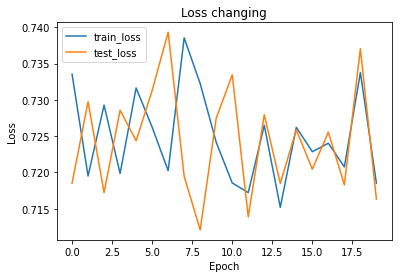

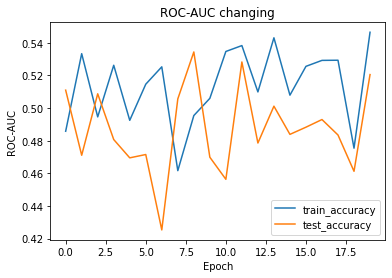

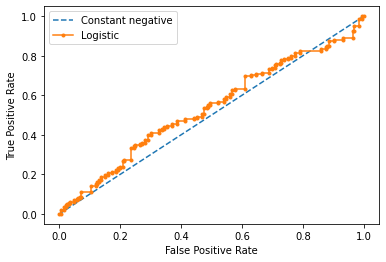

RMS: 0.6784894466400146
Precision score: 0.5079365079365079
Recall score: 0.19875776397515527
Accuracy score: 0.546742209631728
Balanced accuracy score: 0.518649715320911
F1 score: 0.2857142857142857
F1 weighted score: 0.4936701421132439
AUC-ROC score: 0.5344202898550725


In [243]:
plot_loss_changing(train_loss_history, test_loss_history)
plot_roc_auc_changing(train_roc_auc_history, test_roc_auc_history)
plot_roc_auc(test_labels.cpu().detach().numpy(), test_final_predictions)

cnn1_metrics = getMetrics(test_labels, test_final_predictions)

In [18]:
class CNN3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 2), padding=(3, 2))
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 2), padding=(3, 2))
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 2), padding=(2, 1))
        self.bn3 = nn.BatchNorm2d(128)
        
        self.maxpool = nn.MaxPool2d(kernel_size=(2, 1), stride=(1, 1))
        self.avg = nn.AvgPool2d((1, 2))
        self.dropout = nn.Dropout(0.5)
        
        self.fc = nn.Linear(128, 1)
        
    def forward(self, x):
        x = self.dropout(self.maxpool(F.leaky_relu(self.bn1(self.conv1(x)))))
        x = self.dropout(self.maxpool(F.leaky_relu(self.bn2(self.conv2(x)))))
        x = self.dropout(self.maxpool(F.leaky_relu(self.bn3(self.conv3(x)))))
        x = self.avg(x)
        x = x.view(-1, 128)
        x = self.fc(x)
        return x

In [19]:
def full_train_cycle(dataset_annotations_path: str, 
                     dataset_files_path: str,
                     dataset_name: str,
                     model: torch.nn.Module,
                     model_name: str, 
                     device: str, 
                     criterion: torch.nn, 
                     optimizer: torch.optim, 
                     epochs: int,
                     full: bool = False) -> Tuple:
    print(f"{dataset_name}:\n")
    df = pd.read_csv(dataset_annotations_path, sep=';')
    WhalesDataset = AudioDataset(df, dataset_files_path)

    indexes = list(range(0, len(WhalesDataset)))

    train_index = indexes[:round(0.8 * len(WhalesDataset))] if not full else indexes
    test_index = indexes[round(0.8 * len(WhalesDataset)):]

    train_dataset = AudioDataset(df.iloc[train_index], dataset_files_path)
    test_dataset = AudioDataset(df.iloc[test_index].reset_index(), dataset_files_path)
    
    print(f"Train size = {len(train_dataset)}")
    print(f"Test size = {len(test_dataset)}\n")
    
    train_loader = DataLoader(train_dataset, shuffle=True)
    test_loader = DataLoader(test_dataset, shuffle=False)
    
    (model, 
    test_final_predictions, 
    train_loss_history, 
    train_roc_auc_history, 
    test_loss_history, 
    test_roc_auc_history, 
    best_roc_auc) = train(model, model_name, epochs, train_loader, test_loader, criterion, optimizer)
    
    test_labels = torch.empty(0, device=device)
    for data, label in test_loader:
        test_labels = torch.cat((test_labels, label))
    test_labels = torch.squeeze(test_labels)
    
    plot_loss_changing(train_loss_history, test_loss_history)
    plot_roc_auc_changing(train_roc_auc_history, test_roc_auc_history)
    plot_roc_auc(test_labels.cpu().detach().numpy(), test_final_predictions)
    
    print(f"Total results for {model_name} on {dataset_name}:\n")
    
    metrics = getMetrics(test_labels, test_final_predictions)
    
    return model, metrics

## A->A

In [25]:
model_A1 = CNN1()

train_config_A1 = {
    "dataset_annotations_path": "/home/latna/aponom/whales/Canada/data/clips/dataset_A/train/annotations_A_train.csv",
    "dataset_files_path": "/home/latna/aponom/whales/Canada/data/clips/dataset_A/train/audio/",
    "dataset_name": "A->A",
    "model": model_A1,
    "model_name": "5LayerCNN",
    "device": "cpu",
    "criterion": nn.BCEWithLogitsLoss(),
    "optimizer": optim.Adam(model_A1.parameters(), lr=0.01),
    "epochs": 20
}

A->A:

Train size = 1414
Test size = 353



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 1
Train Loss = 0.831615686416626, Train ROC-AUC = 0.5015325931476057
Test Loss = 0.695205569267273, Test ROC-AUC = 0.5179865424430642
Model saved successfully



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 2
Train Loss = 0.6954795122146606, Train ROC-AUC = 0.500748235711794
Test Loss = 0.6901594400405884, Test ROC-AUC = 0.47182324016563143



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 3
Train Loss = 0.6902018785476685, Train ROC-AUC = 0.5017431311961658
Test Loss = 0.7432231307029724, Test ROC-AUC = 0.5200892857142858
Model saved successfully



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 4
Train Loss = 0.691410481929779, Train ROC-AUC = 0.5220084504193216
Test Loss = 0.7083219289779663, Test ROC-AUC = 0.4664855072463768



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 5
Train Loss = 0.6905659437179565, Train ROC-AUC = 0.5052665473617725
Test Loss = 0.6897451877593994, Test ROC-AUC = 0.5193775879917184



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 6
Train Loss = 0.6877308487892151, Train ROC-AUC = 0.5056979439514689
Test Loss = 0.6994662880897522, Test ROC-AUC = 0.5178571428571428



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 7
Train Loss = 0.6903543472290039, Train ROC-AUC = 0.48811182460116453
Test Loss = 0.6904885768890381, Test ROC-AUC = 0.5175336438923396



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 8
Train Loss = 0.6972503662109375, Train ROC-AUC = 0.5005253130721423
Test Loss = 0.7031557559967041, Test ROC-AUC = 0.5054671325051759



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 9
Train Loss = 0.6914490461349487, Train ROC-AUC = 0.5209557601765217
Test Loss = 0.7241734266281128, Test ROC-AUC = 0.5199922360248448



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 10
Train Loss = 0.6973220109939575, Train ROC-AUC = 0.44987233550682904
Test Loss = 0.9452338218688965, Test ROC-AUC = 0.504690734989648



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 11
Train Loss = 0.6939852237701416, Train ROC-AUC = 0.5019433487521492
Test Loss = 0.710536003112793, Test ROC-AUC = 0.5096079192546583



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 12
Train Loss = 0.6971599459648132, Train ROC-AUC = 0.4950410033170063
Test Loss = 0.7273684144020081, Test ROC-AUC = 0.5079257246376812



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 13
Train Loss = 0.6953761577606201, Train ROC-AUC = 0.4717724207540978
Test Loss = 0.6908698081970215, Test ROC-AUC = 0.5233889751552795
Model saved successfully



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 14
Train Loss = 0.6927478313446045, Train ROC-AUC = 0.5062015839892007
Test Loss = 0.6907404661178589, Test ROC-AUC = 0.5362965838509317
Model saved successfully



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 15
Train Loss = 0.6902163028717041, Train ROC-AUC = 0.5106455880926285
Test Loss = 0.6937064528465271, Test ROC-AUC = 0.4969267598343685



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 16
Train Loss = 0.6902404427528381, Train ROC-AUC = 0.48145097869231107
Test Loss = 0.6909161806106567, Test ROC-AUC = 0.49042443064182195



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 17
Train Loss = 0.6948570013046265, Train ROC-AUC = 0.4892904248533974
Test Loss = 0.690051794052124, Test ROC-AUC = 0.5039790372670807



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 18
Train Loss = 0.7002540230751038, Train ROC-AUC = 0.48715408289006823
Test Loss = 0.6929886937141418, Test ROC-AUC = 0.49398291925465837



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 19
Train Loss = 0.6970392465591431, Train ROC-AUC = 0.48274516846140025
Test Loss = 0.7002161145210266, Test ROC-AUC = 0.5288884575569358



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 20
Train Loss = 0.6942912936210632, Train ROC-AUC = 0.5001434548468129
Test Loss = 0.6986633539199829, Test ROC-AUC = 0.5034290890269151



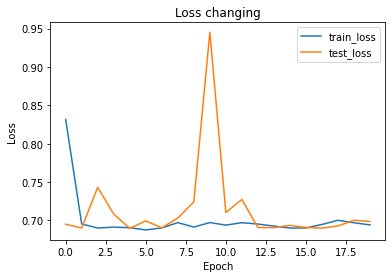

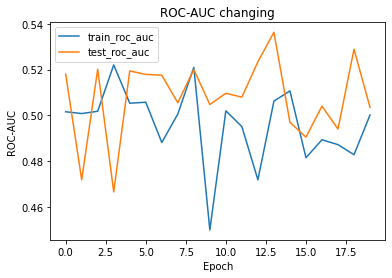

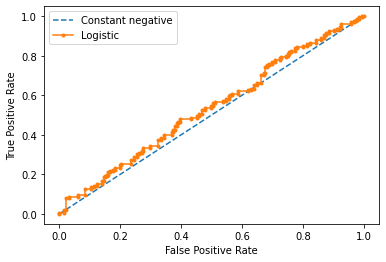

Total results for 5LayerCNN on A->A:

RMS: 0.6879240870475769
Precision score: 0.0
Recall score: 0.0
Accuracy score: 0.5439093484419264
Balanced accuracy score: 0.5
F1 score: 0.0
F1 weighted score: 0.38323154092054995
AUC-ROC score: 0.5362965838509317
CPU times: user 4h 29min 29s, sys: 2min 38s, total: 4h 32min 7s
Wall time: 24min 12s


In [26]:
%%time
(model_A1, metrics_A1) = full_train_cycle(**train_config_A1)

In [32]:
model_A2 = CNN2()

train_config_A2 = {
    "dataset_annotations_path": "/home/latna/aponom/whales/Canada/data/clips/dataset_A/train/annotations_A_train.csv",
    "dataset_files_path": "/home/latna/aponom/whales/Canada/data/clips/dataset_A/train/audio/",
    "dataset_name": "A->A",
    "model": model_A2,
    "model_name": "7LayerCNN",
    "device": "cpu",
    "criterion": nn.BCEWithLogitsLoss(),
    "optimizer": optim.Adam(model_A2.parameters(), lr=0.01),
    "epochs": 20
}

A->A:

Train size = 1414
Test size = 353



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 1
Train Loss = 2.3515257835388184, Train ROC-AUC = 0.5174942669663738
Test Loss = 0.9771308302879333, Test ROC-AUC = 0.5163366977225672
Model saved successfully



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 2
Train Loss = 0.8139510154724121, Train ROC-AUC = 0.5266155183054577
Test Loss = 0.8252947330474854, Test ROC-AUC = 0.4831133540372671



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 3
Train Loss = 0.795198917388916, Train ROC-AUC = 0.5273730424605705
Test Loss = 0.75123530626297, Test ROC-AUC = 0.531347049689441
Model saved successfully



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 4
Train Loss = 0.8126322627067566, Train ROC-AUC = 0.5276950418289564
Test Loss = 0.9696668982505798, Test ROC-AUC = 0.4916537267080746



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 5
Train Loss = 0.8016717433929443, Train ROC-AUC = 0.5269086202946295
Test Loss = 0.696563720703125, Test ROC-AUC = 0.5317675983436853
Model saved successfully



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 6
Train Loss = 0.7848971486091614, Train ROC-AUC = 0.5330245441954453
Test Loss = 0.7582900524139404, Test ROC-AUC = 0.5646674430641823
Model saved successfully



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 7
Train Loss = 0.7822163701057434, Train ROC-AUC = 0.5087053354882523
Test Loss = 1.0564677715301514, Test ROC-AUC = 0.5094785196687371



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 8
Train Loss = 0.807961106300354, Train ROC-AUC = 0.5381104829371296
Test Loss = 0.7388523817062378, Test ROC-AUC = 0.4859924948240166



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 9
Train Loss = 0.7879860401153564, Train ROC-AUC = 0.5025584501097068
Test Loss = 0.7047245502471924, Test ROC-AUC = 0.5097373188405797



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 10
Train Loss = 0.8169636726379395, Train ROC-AUC = 0.5362899480466403
Test Loss = 0.9148131608963013, Test ROC-AUC = 0.5390786749482401



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 11
Train Loss = 0.7800426483154297, Train ROC-AUC = 0.5433636136585527
Test Loss = 1.3984973430633545, Test ROC-AUC = 0.46380046583850937



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 12
Train Loss = 0.8066151738166809, Train ROC-AUC = 0.527187273594194
Test Loss = 0.7058541178703308, Test ROC-AUC = 0.5214803312629399



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 13
Train Loss = 0.7719189524650574, Train ROC-AUC = 0.5216472331791453
Test Loss = 0.775122880935669, Test ROC-AUC = 0.49029503105590067



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 14
Train Loss = 0.7599129676818848, Train ROC-AUC = 0.520466568828397
Test Loss = 0.8061375617980957, Test ROC-AUC = 0.4751876293995859



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 15
Train Loss = 0.83305823802948, Train ROC-AUC = 0.5476301052896653
Test Loss = 0.7841583490371704, Test ROC-AUC = 0.5052406832298137



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 16
Train Loss = 0.8002703785896301, Train ROC-AUC = 0.54755786184163
Test Loss = 0.7868744134902954, Test ROC-AUC = 0.4991265527950311



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 17
Train Loss = 0.7615579962730408, Train ROC-AUC = 0.5611004122004735
Test Loss = 0.9988422393798828, Test ROC-AUC = 0.5180512422360248



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 18
Train Loss = 0.8044283390045166, Train ROC-AUC = 0.5188834052671666
Test Loss = 1.3835015296936035, Test ROC-AUC = 0.5173718944099379



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 19
Train Loss = 0.8061180114746094, Train ROC-AUC = 0.5677798349959647
Test Loss = 0.8630397319793701, Test ROC-AUC = 0.4866394927536232



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 20
Train Loss = 0.7821781039237976, Train ROC-AUC = 0.5387359047872637
Test Loss = 0.7907720804214478, Test ROC-AUC = 0.5189570393374741



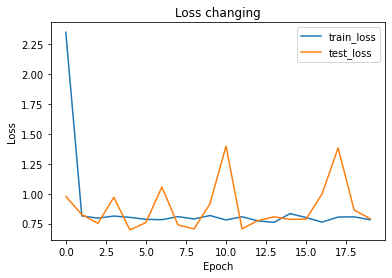

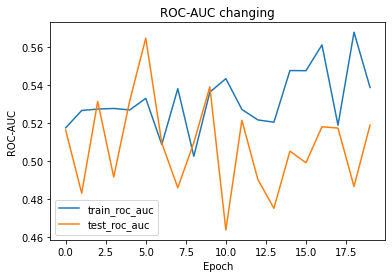

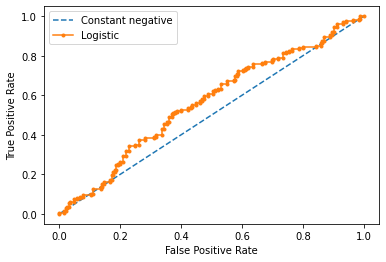

Total results for 7LayerCNN on A->A:

RMS: 1.1139243841171265
Precision score: 0.5
Recall score: 0.39751552795031053
Accuracy score: 0.5439093484419264
Balanced accuracy score: 0.5320910973084886
F1 score: 0.4429065743944636
F1 weighted score: 0.5359163231575947
AUC-ROC score: 0.5646674430641823
CPU times: user 1d 11h 34min 57s, sys: 2h 50min 33s, total: 1d 14h 25min 31s
Wall time: 3h 36min 27s


In [33]:
%%time
(model_A2, metrics_A2) = full_train_cycle(**train_config_A2)

In [34]:
model_A3 = CNN3()

train_config_A3 = {
    "dataset_annotations_path": "/home/latna/aponom/whales/Canada/data/clips/dataset_A/train/annotations_A_train.csv",
    "dataset_files_path": "/home/latna/aponom/whales/Canada/data/clips/dataset_A/train/audio/",
    "dataset_name": "A->A",
    "model": model_A3,
    "model_name": "3LayerCNN",
    "device": "cpu",
    "criterion": nn.BCEWithLogitsLoss(),
    "optimizer": optim.Adam(model_A3.parameters(), lr=0.01),
    "epochs": 20
}

A->A:

Train size = 1414
Test size = 353



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 1
Train Loss = 0.7236180305480957, Train ROC-AUC = 0.5433801264466751
Test Loss = 0.6906517744064331, Test ROC-AUC = 0.5464221014492753
Model saved successfully



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 2
Train Loss = 0.6799187064170837, Train ROC-AUC = 0.5032788204915444
Test Loss = 0.6899800300598145, Test ROC-AUC = 0.5189570393374741



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 3
Train Loss = 0.6790458559989929, Train ROC-AUC = 0.49989163482794713
Test Loss = 0.7028086185455322, Test ROC-AUC = 0.47444358178053836



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 4
Train Loss = 0.6812663078308105, Train ROC-AUC = 0.4679497103037734
Test Loss = 0.6959877610206604, Test ROC-AUC = 0.489939182194617



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 5
Train Loss = 0.6783912777900696, Train ROC-AUC = 0.5066556856625652
Test Loss = 0.6909971833229065, Test ROC-AUC = 0.5179865424430642



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 6
Train Loss = 0.6798489093780518, Train ROC-AUC = 0.4995428021788624
Test Loss = 0.6920092701911926, Test ROC-AUC = 0.4655797101449275



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 7
Train Loss = 0.688389003276825, Train ROC-AUC = 0.5067258650120854
Test Loss = 0.7010474801063538, Test ROC-AUC = 0.5588121118012422
Model saved successfully



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 8
Train Loss = 0.6786983013153076, Train ROC-AUC = 0.5103999603693085
Test Loss = 0.6890348196029663, Test ROC-AUC = 0.5774133022774327
Model saved successfully



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 9
Train Loss = 0.6710485816001892, Train ROC-AUC = 0.5678541425425153
Test Loss = 0.6808763146400452, Test ROC-AUC = 0.5743724120082816



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 10
Train Loss = 0.6578388810157776, Train ROC-AUC = 0.6242680190640139
Test Loss = 0.7157489657402039, Test ROC-AUC = 0.5805512422360248
Model saved successfully



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 11
Train Loss = 0.6558074951171875, Train ROC-AUC = 0.6210129357053953
Test Loss = 0.6878191232681274, Test ROC-AUC = 0.5850478778467909
Model saved successfully



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 12
Train Loss = 0.6476149559020996, Train ROC-AUC = 0.6406714099650548
Test Loss = 0.7024732232093811, Test ROC-AUC = 0.5736283643892339



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 13
Train Loss = 0.6492778062820435, Train ROC-AUC = 0.6376619543297563
Test Loss = 0.6892088055610657, Test ROC-AUC = 0.5897709627329193
Model saved successfully



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 14
Train Loss = 0.6428772807121277, Train ROC-AUC = 0.6499784301705152
Test Loss = 0.7027173042297363, Test ROC-AUC = 0.5888004658385093



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 15
Train Loss = 0.6465727686882019, Train ROC-AUC = 0.6415713569177229
Test Loss = 0.6916393041610718, Test ROC-AUC = 0.5918090062111803
Model saved successfully



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 16
Train Loss = 0.6478961110115051, Train ROC-AUC = 0.6438129679053323
Test Loss = 0.693682074546814, Test ROC-AUC = 0.5733048654244306



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 17
Train Loss = 0.6360718011856079, Train ROC-AUC = 0.6658864374278857
Test Loss = 0.68206787109375, Test ROC-AUC = 0.6144215838509317
Model saved successfully



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 18
Train Loss = 0.6427780389785767, Train ROC-AUC = 0.6540756657233737
Test Loss = 0.6992496848106384, Test ROC-AUC = 0.5850802277432712



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 19
Train Loss = 0.6434034109115601, Train ROC-AUC = 0.656922057575964
Test Loss = 0.7084254622459412, Test ROC-AUC = 0.5624353002070394



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 20
Train Loss = 0.6360727548599243, Train ROC-AUC = 0.6646417860231633
Test Loss = 0.7213827967643738, Test ROC-AUC = 0.5292766563146998



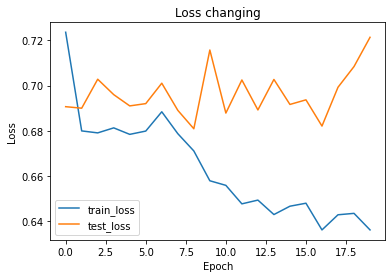

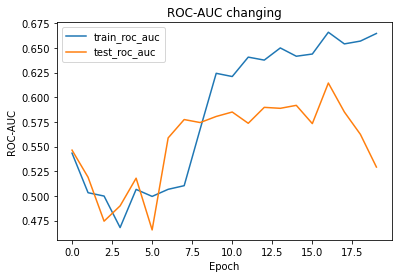

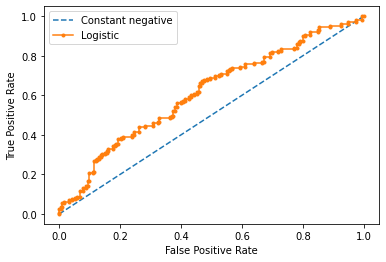

Total results for 3LayerCNN on A->A:

RMS: 1.1376088857650757
Precision score: 0.5666666666666667
Recall score: 0.10559006211180125
Accuracy score: 0.5552407932011332
Balanced accuracy score: 0.5189408643892339
F1 score: 0.1780104712041885
F1 weighted score: 0.45928511906210445
AUC-ROC score: 0.6144215838509317
CPU times: user 3h 46min 10s, sys: 1min 40s, total: 3h 47min 50s
Wall time: 20min 14s


In [35]:
%%time
(model_A3, metrics_A3) = full_train_cycle(**train_config_A3)

In [36]:
WhalesDataset = AudioDataset(pd.read_csv("/home/latna/aponom/whales/Canada/data/clips/dataset_A/train/annotations_A_train.csv", sep=';'), 
                             "/home/latna/aponom/whales/Canada/data/clips/dataset_A/train/audio/")
test_loader = DataLoader(WhalesDataset, shuffle=False)
test_predictions = torch.empty(0, device=device)
test_labels = torch.empty(0, device=device)
with torch.no_grad():
    for data, label in tqdm(test_loader, total=len(test_loader)):
        data, label = data.to(device).float(), label.to(device).float()
        predictions = torch.as_tensor((0.5 * torch.as_tensor(model_A3(data)[0]) + 0.3 * torch.as_tensor(model_A2(data)[0]) + 0.2 * torch.as_tensor(model_A1(data)[0])))
        test_predictions = torch.cat((test_predictions, predictions))
        test_labels = torch.cat((test_labels, label))
    test_predictions = torch.squeeze(test_predictions)
    test_labels = torch.squeeze(test_labels)

  0%|          | 0/1767 [00:00<?, ?it/s]

In [37]:
from xgboost import XGBRegressor

xgb_params = {
    'objective': 'binary:logistic', 
    'n_estimators': 750, 
    'scale_pos_weight': 9
}

xgb_model = XGBRegressor(**xgb_params)

In [40]:
xgb_indexes = list(range(0, len(test_labels)))

xgb_train_indexes = xgb_indexes[:round(0.8 * len(test_labels))]
xgb_test_indexes = xgb_indexes[round(0.8 * len(test_labels)):]

xgb_X_train = test_predictions[np.array(xgb_train_indexes)]
xgb_Y_train = test_labels[np.array(xgb_train_indexes)]
xgb_X_test = test_predictions[np.array(xgb_test_indexes)]
xgb_Y_test = test_labels[np.array(xgb_test_indexes)]

In [46]:
%%time
xgb_model.fit(np.array(xgb_X_train).reshape(-1, 1), np.array(xgb_Y_train).reshape(-1, 1))

[22:43:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 1min 19s, sys: 190 ms, total: 1min 19s
Wall time: 3.79 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=750, n_jobs=24, num_parallel_tree=1,
             objective='binary:logistic', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=9, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [49]:
metrics_AA_xgb = getMetrics(test_labels.cpu().detach().numpy(), 
                            xgb_model.predict(test_predictions.cpu().detach().numpy().reshape(-1, 1)))

RMS: 0.35270488262176514
Precision score: 0.7403846153846154
Recall score: 0.9314516129032258
Accuracy score: 0.833616298811545
Balanced accuracy score: 0.8469574780058651
F1 score: 0.825
F1 weighted score: 0.8345086016010902
AUC-ROC score: 0.9242982635932688


## B->B

In [40]:
model_B1 = CNN1()

train_config_B1 = {
    "dataset_annotations_path": "/home/latna/aponom/whales/Canada/data/clips/dataset_B/train/annotations_B_train.csv",
    "dataset_files_path": "/home/latna/aponom/whales/Canada/data/clips/dataset_B/train/audio/",
    "dataset_name": "B->B",
    "model": model_B1,
    "model_name": "5LayerCNN",
    "device": "cpu",
    "criterion": nn.BCEWithLogitsLoss(),
    "optimizer": optim.Adam(model_B1.parameters(), lr=0.01),
    "epochs": 10
}

B->B:

Train size = 2647
Test size = 662



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 1
Train Loss = 0.7579248547554016, Train ROC-AUC = 0.512001670928256
Test Loss = 0.6715604066848755, Test ROC-AUC = 0.48132435227151926



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 2
Train Loss = 0.6775436401367188, Train ROC-AUC = 0.5165034261252281
Test Loss = 0.6754599213600159, Test ROC-AUC = 0.5166655392019482
Model saved successfully



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 3
Train Loss = 0.6849837303161621, Train ROC-AUC = 0.49325248351944684
Test Loss = 0.673340380191803, Test ROC-AUC = 0.5069532359848081



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 4
Train Loss = 0.6878054738044739, Train ROC-AUC = 0.48369761495456715
Test Loss = 0.6662604808807373, Test ROC-AUC = 0.5049141355083738



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 5
Train Loss = 0.688325822353363, Train ROC-AUC = 0.5029560261762709
Test Loss = 0.6657081246376038, Test ROC-AUC = 0.5107221894720566



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 6
Train Loss = 0.686393678188324, Train ROC-AUC = 0.4967821388844748
Test Loss = 0.6695308685302734, Test ROC-AUC = 0.5327657353808093
Model saved successfully



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 7
Train Loss = 0.6819339394569397, Train ROC-AUC = 0.5048544799657146
Test Loss = 0.6658060550689697, Test ROC-AUC = 0.5013771176203408



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 8
Train Loss = 0.6796888113021851, Train ROC-AUC = 0.5164709224775965
Test Loss = 0.6849752068519592, Test ROC-AUC = 0.473428877914899



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 9
Train Loss = 0.6799391508102417, Train ROC-AUC = 0.503077613895189
Test Loss = 0.6681338548660278, Test ROC-AUC = 0.4833731167312542



  0%|          | 0/2647 [00:00<?, ?it/s]

Test Loss = 0.6794353127479553, Test ROC-AUC = 0.49228330933444153



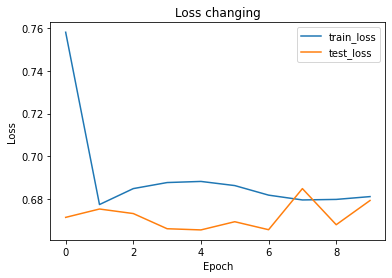

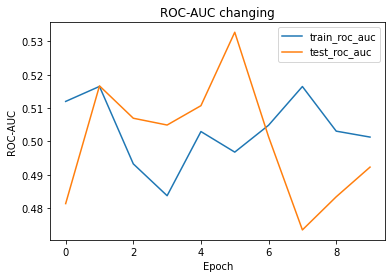

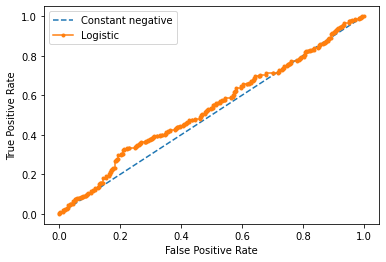

Total results for 5LayerCNN on B->B:

RMS: 0.49422359466552734
Precision score: 0.6178247734138973
Recall score: 1.0
Accuracy score: 0.6178247734138973
Balanced accuracy score: 0.5
F1 score: 0.7637721755368815
F1 weighted score: 0.4718773712909132
AUC-ROC score: 0.5327657353808093
CPU times: user 1d 7h 27min 33s, sys: 25min 35s, total: 1d 7h 53min 8s
Wall time: 1h 43min 40s


In [41]:
%%time
(model_B1, metrics_B1) = full_train_cycle(**train_config_B1)

In [50]:
model_B2 = CNN2()

train_config_B2 = {
    "dataset_annotations_path": "/home/latna/aponom/whales/Canada/data/clips/dataset_B/train/annotations_B_train.csv",
    "dataset_files_path": "/home/latna/aponom/whales/Canada/data/clips/dataset_B/train/audio/",
    "dataset_name": "B->B",
    "model": model_B2,
    "model_name": "7LayerCNN",
    "device": "cpu",
    "criterion": nn.BCEWithLogitsLoss(),
    "optimizer": optim.Adam(model_B2.parameters(), lr=0.01),
    "epochs": 5
}

B->B:

Train size = 2647
Test size = 662



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 1
Train Loss = 1.5283571481704712, Train ROC-AUC = 0.5012604192248241
Test Loss = 0.7258861064910889, Test ROC-AUC = 0.5157764527382895
Model saved successfully



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 2
Train Loss = 0.7578650712966919, Train ROC-AUC = 0.4963692221756738
Test Loss = 0.6715900301933289, Test ROC-AUC = 0.5158054446881916
Model saved successfully



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 3
Train Loss = 0.7905024290084839, Train ROC-AUC = 0.4920934877136212
Test Loss = 1.0000382661819458, Test ROC-AUC = 0.5026430994327242



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 4
Train Loss = 0.7829537391662598, Train ROC-AUC = 0.5071315410581261
Test Loss = 0.8346928358078003, Test ROC-AUC = 0.5035611778462846



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 5
Train Loss = 0.8139995336532593, Train ROC-AUC = 0.5046901559693551
Test Loss = 0.6840829849243164, Test ROC-AUC = 0.5219130821341941
Model saved successfully



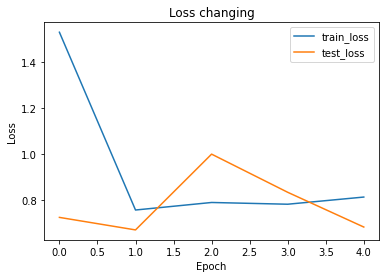

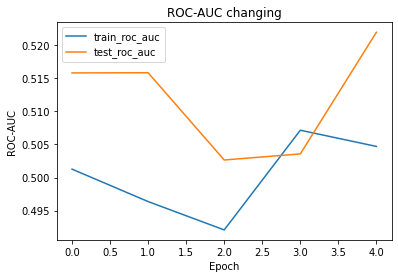

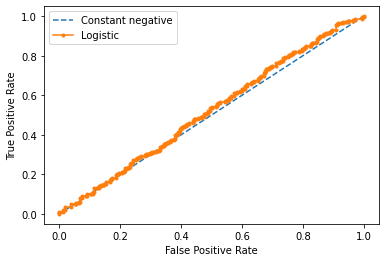

Total results for 7LayerCNN on B->B:

RMS: 0.7358439564704895
Precision score: 0.6666666666666666
Recall score: 0.014669926650366748
Accuracy score: 0.3867069486404834
Balanced accuracy score: 0.5014061095702427
F1 score: 0.02870813397129187
F1 weighted score: 0.22865007682185573
AUC-ROC score: 0.5219130821341941
CPU times: user 1d 21h 31min 54s, sys: 1h 35min 52s, total: 1d 23h 7min 46s
Wall time: 2h 36min 58s


In [51]:
%%time
(model_B2, metrics_B2) = full_train_cycle(**train_config_B2)

In [52]:
model_B3 = CNN3()

train_config_B3 = {
    "dataset_annotations_path": "/home/latna/aponom/whales/Canada/data/clips/dataset_B/train/annotations_B_train.csv",
    "dataset_files_path": "/home/latna/aponom/whales/Canada/data/clips/dataset_B/train/audio/",
    "dataset_name": "B->B",
    "model": model_B3,
    "model_name": "3LayerCNN",
    "device": "cpu",
    "criterion": nn.BCEWithLogitsLoss(),
    "optimizer": optim.Adam(model_B3.parameters(), lr=0.01),
    "epochs": 15
}

B->B:

Train size = 2647
Test size = 662



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 1
Train Loss = 0.6803611516952515, Train ROC-AUC = 0.5095626935170873
Test Loss = 0.6712965965270996, Test ROC-AUC = 0.4776423746339766



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 2
Train Loss = 0.6685225367546082, Train ROC-AUC = 0.49938062493679847
Test Loss = 0.6662501096725464, Test ROC-AUC = 0.49955062477652035



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 3
Train Loss = 0.6708160638809204, Train ROC-AUC = 0.47822676952265386
Test Loss = 0.6657117605209351, Test ROC-AUC = 0.4994443209602133



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 4
Train Loss = 0.6678188443183899, Train ROC-AUC = 0.5076546090172342
Test Loss = 0.6701881289482117, Test ROC-AUC = 0.5232370478463814
Model saved successfully



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 5
Train Loss = 0.6719889044761658, Train ROC-AUC = 0.5012956315097583
Test Loss = 0.6715888381004333, Test ROC-AUC = 0.5212849232196527



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 6
Train Loss = 0.6703903079032898, Train ROC-AUC = 0.4870503060158233
Test Loss = 0.6658905744552612, Test ROC-AUC = 0.48453279472733074



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 7
Train Loss = 0.668694257736206, Train ROC-AUC = 0.5037279878075207
Test Loss = 0.6657941937446594, Test ROC-AUC = 0.5358678740203138
Model saved successfully



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 8
Train Loss = 0.6711264252662659, Train ROC-AUC = 0.48953081586563235
Test Loss = 0.6656236052513123, Test ROC-AUC = 0.48466809049353965



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 9
Train Loss = 0.6685779690742493, Train ROC-AUC = 0.5042829574948596
Test Loss = 0.6684887409210205, Test ROC-AUC = 0.47766653459222824



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 10
Train Loss = 0.6699537634849548, Train ROC-AUC = 0.5097649384356837
Test Loss = 0.6659840941429138, Test ROC-AUC = 0.5331233027629328



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 11
Train Loss = 0.6695163249969482, Train ROC-AUC = 0.4966033688225012
Test Loss = 0.6659542322158813, Test ROC-AUC = 0.4847840582931473



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 12
Train Loss = 0.6721503734588623, Train ROC-AUC = 0.4902669632925472
Test Loss = 0.6644812822341919, Test ROC-AUC = 0.5316930332344385



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 13
Train Loss = 0.6697781085968018, Train ROC-AUC = 0.4961125035513244
Test Loss = 0.6733614802360535, Test ROC-AUC = 0.49416778607806566



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 14
Train Loss = 0.6703996658325195, Train ROC-AUC = 0.4928100727600171
Test Loss = 0.6665826439857483, Test ROC-AUC = 0.4754099944915295



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 15
Train Loss = 0.6690889596939087, Train ROC-AUC = 0.5044210979972938
Test Loss = 0.6682188510894775, Test ROC-AUC = 0.47746842293456515



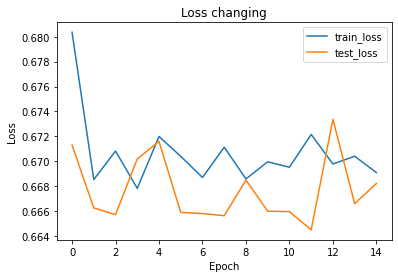

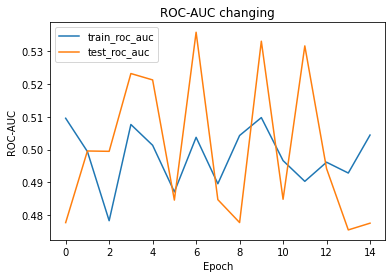

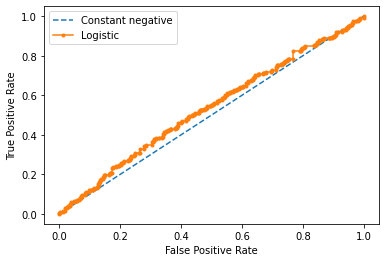

Total results for 3LayerCNN on B->B:

RMS: 0.48904308676719666
Precision score: 0.6170212765957447
Recall score: 0.9926650366748166
Accuracy score: 0.6148036253776435
Balanced accuracy score: 0.49830880292238855
F1 score: 0.7610121836925959
F1 weighted score: 0.4731463062320279
AUC-ROC score: 0.5358678740203138
CPU times: user 1d 5h 13min 47s, sys: 18min 31s, total: 1d 5h 32min 19s
Wall time: 1h 33min 11s


In [53]:
%%time
(model_B3, metrics_B3) = full_train_cycle(**train_config_B3)

In [54]:
WhalesDataset = AudioDataset(pd.read_csv("/home/latna/aponom/whales/Canada/data/clips/dataset_B/train/annotations_B_train.csv", sep=';'), 
                             "/home/latna/aponom/whales/Canada/data/clips/dataset_B/train/audio/")
test_predictions = torch.empty(0, device=device)
test_loader = DataLoader(WhalesDataset, shuffle=False)
test_labels = torch.empty(0, device=device)
with torch.no_grad():
    for data, label in tqdm(test_loader, total=len(test_loader)):
        data, label = data.to(device).float(), label.to(device).float()
        predictions = torch.as_tensor((0.5 * torch.as_tensor(model_B1(data)[0]) + 0.3 * torch.as_tensor(model_B3(data)[0])) + 0.2 * torch.as_tensor(model_B2(data)[0]))
        test_predictions = torch.cat((test_predictions, predictions))
        test_labels = torch.cat((test_labels, label))
    test_predictions = torch.squeeze(test_predictions)
    test_labels = torch.squeeze(test_labels)

  0%|          | 0/3309 [00:00<?, ?it/s]

In [55]:
xgb_params = {
    'objective': 'binary:logistic', 
    'n_estimators': 750, 
    'scale_pos_weight': 9
}

xgb_model = XGBRegressor(**xgb_params)

In [56]:
test_labels = test_labels.cpu().detach().numpy()
test_predictions = test_predictions.cpu().detach().numpy()

xgb_indexes = list(range(0, len(test_labels)))

xgb_train_indexes = xgb_indexes[:round(0.8 * len(test_labels))]
xgb_test_indexes = xgb_indexes[round(0.8 * len(test_labels)):]

xgb_X_train = test_predictions[np.array(xgb_train_indexes)]
xgb_Y_train = test_labels[np.array(xgb_train_indexes)]
xgb_X_test = test_predictions[np.array(xgb_test_indexes)]
xgb_Y_test = test_labels[np.array(xgb_test_indexes)]

In [57]:
%%time
xgb_model.fit(np.array(xgb_X_train).reshape(-1, 1), np.array(xgb_Y_train).reshape(-1, 1))

[16:28:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 1min 25s, sys: 535 ms, total: 1min 26s
Wall time: 4.49 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=750, n_jobs=24, num_parallel_tree=1,
             objective='binary:logistic', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=9, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [58]:
preds = xgb_model.predict(np.array(xgb_X_test).reshape(-1, 1))
metrics_BB_xgb = getMetrics(np.array(xgb_Y_test), preds)

RMS: 0.5678150653839111
Precision score: 0.6338983050847458
Recall score: 0.9144254278728606
Accuracy score: 0.620845921450151
Balanced accuracy score: 0.5303352435806991
F1 score: 0.7487487487487486
F1 weighted score: 0.5496138853238549
AUC-ROC score: 0.5259719551204616


In [65]:
threshold = find_best_threshold(np.array(xgb_Y_test), preds)[1]

In [66]:
metrics_BB_xgb_ = getMetrics(np.array(xgb_Y_test), preds, threshold=threshold)

RMS: 0.5678150653839111
Precision score: 0.6430817610062893
Recall score: 1.0
Accuracy score: 0.6570996978851964
Balanced accuracy score: 0.5513833992094862
F1 score: 0.7827751196172249
F1 weighted score: 0.5548476522465925
AUC-ROC score: 0.5259719551204616


---

### A->B

In [20]:
model_AB1 = CNN1()

train_config_AB1 = {
    "dataset_annotations_path": "/home/latna/aponom/whales/Canada/data/clips/dataset_A/train/annotations_A_train.csv",
    "dataset_files_path": "/home/latna/aponom/whales/Canada/data/clips/dataset_A/train/audio/",
    "dataset_name": "A->B",
    "model": model_AB1,
    "model_name": "5LayerCNN",
    "device": "cpu",
    "criterion": nn.BCEWithLogitsLoss(),
    "optimizer": optim.Adam(model_AB1.parameters(), lr=0.01),
    "epochs": 10,
    "full": True
}

A->B:

Train size = 1767
Test size = 353



  0%|          | 0/1767 [00:00<?, ?it/s]

Epoch: 1
Train Loss = 0.8060611486434937, Train ROC-AUC = 0.5159858207464867
Test Loss = 0.7386025190353394, Test ROC-AUC = 0.483889751552795



  0%|          | 0/1767 [00:00<?, ?it/s]

Epoch: 2
Train Loss = 0.6924463510513306, Train ROC-AUC = 0.5146588149970044
Test Loss = 0.6897304654121399, Test ROC-AUC = 0.5014233954451346
Model saved successfully



  0%|          | 0/1767 [00:00<?, ?it/s]

Epoch: 3
Train Loss = 0.6899375915527344, Train ROC-AUC = 0.5077544434984602
Test Loss = 0.6872503161430359, Test ROC-AUC = 0.5724314182194618
Model saved successfully



  0%|          | 0/1767 [00:00<?, ?it/s]

Epoch: 4
Train Loss = 0.6979272961616516, Train ROC-AUC = 0.480582358443961
Test Loss = 0.6952381730079651, Test ROC-AUC = 0.4672295548654245



  0%|          | 0/1767 [00:00<?, ?it/s]

Epoch: 5
Train Loss = 0.6928690671920776, Train ROC-AUC = 0.49913416159513974
Test Loss = 0.6897591352462769, Test ROC-AUC = 0.5434459109730849



  0%|          | 0/1767 [00:00<?, ?it/s]

Epoch: 6
Train Loss = 0.6947780847549438, Train ROC-AUC = 0.5165113675779649
Test Loss = 0.7005177140235901, Test ROC-AUC = 0.5943322981366461
Model saved successfully



  0%|          | 0/1767 [00:00<?, ?it/s]

Epoch: 7
Train Loss = 0.6986805200576782, Train ROC-AUC = 0.5291021557931027
Test Loss = 0.6738266348838806, Test ROC-AUC = 0.6538561076604554
Model saved successfully



  0%|          | 0/1767 [00:00<?, ?it/s]

Epoch: 8
Train Loss = 0.696016252040863, Train ROC-AUC = 0.5071566339776538
Test Loss = 0.6924974918365479, Test ROC-AUC = 0.4751876293995859



  0%|          | 0/1767 [00:00<?, ?it/s]

Epoch: 9
Train Loss = 0.6927797198295593, Train ROC-AUC = 0.5362758700427795
Test Loss = 0.6918673515319824, Test ROC-AUC = 0.5179865424430642



  0%|          | 0/1767 [00:00<?, ?it/s]

Epoch: 10
Train Loss = 0.6962928771972656, Train ROC-AUC = 0.5265532536604336
Test Loss = 0.6913696527481079, Test ROC-AUC = 0.6204386645962733



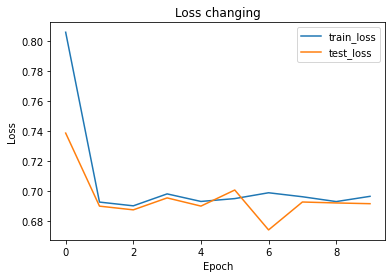

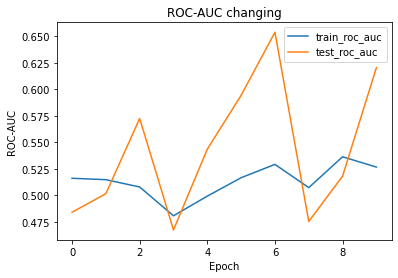

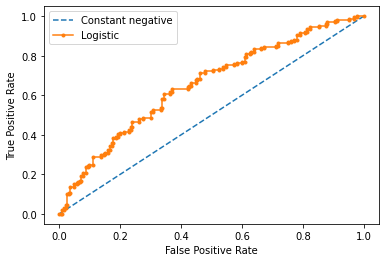

Total results for 5LayerCNN on A->B:

RMS: 0.9630299806594849
Precision score: 0.0
Recall score: 0.0
Accuracy score: 0.5439093484419264
Balanced accuracy score: 0.5
F1 score: 0.0
F1 weighted score: 0.38323154092054995
AUC-ROC score: 0.6538561076604554
CPU times: user 3h 7min 9s, sys: 2min 3s, total: 3h 9min 13s
Wall time: 16min 49s


In [21]:
%%time
(model_AB1, metrics_AB1) = full_train_cycle(**train_config_AB1)

In [22]:
model_AB2 = CNN2()

train_config_AB2 = {
    "dataset_annotations_path": "/home/latna/aponom/whales/Canada/data/clips/dataset_A/train/annotations_A_train.csv",
    "dataset_files_path": "/home/latna/aponom/whales/Canada/data/clips/dataset_A/train/audio/",
    "dataset_name": "A->B",
    "model": model_AB2,
    "model_name": "7LayerCNN",
    "device": "cpu",
    "criterion": nn.BCEWithLogitsLoss(),
    "optimizer": optim.Adam(model_AB2.parameters(), lr=0.01),
    "epochs": 10,
    "full": True
}

A->B:

Train size = 1767
Test size = 353



  0%|          | 0/1767 [00:00<?, ?it/s]

Epoch: 1
Train Loss = 1.5366322994232178, Train ROC-AUC = 0.48199476555355847
Test Loss = 0.7489511370658875, Test ROC-AUC = 0.5085403726708074
Model saved successfully



  0%|          | 0/1767 [00:00<?, ?it/s]

Epoch: 2
Train Loss = 0.7498214840888977, Train ROC-AUC = 0.516044944765028
Test Loss = 0.7646946310997009, Test ROC-AUC = 0.5272062629399585
Model saved successfully



  0%|          | 0/1767 [00:00<?, ?it/s]

Epoch: 3
Train Loss = 0.7746582627296448, Train ROC-AUC = 0.5025397050631182
Test Loss = 0.9187124967575073, Test ROC-AUC = 0.4380175983436853



  0%|          | 0/1767 [00:00<?, ?it/s]

Epoch: 4
Train Loss = 0.7894307374954224, Train ROC-AUC = 0.47794936881825545
Test Loss = 0.7192073464393616, Test ROC-AUC = 0.4162461180124223



  0%|          | 0/1767 [00:00<?, ?it/s]

Epoch: 5
Train Loss = 0.8059235215187073, Train ROC-AUC = 0.5128194010868309
Test Loss = 0.7831207513809204, Test ROC-AUC = 0.4575892857142857



  0%|          | 0/1767 [00:00<?, ?it/s]

Epoch: 6
Train Loss = 0.7884030342102051, Train ROC-AUC = 0.48220235655199234
Test Loss = 1.2250852584838867, Test ROC-AUC = 0.5606237060041407
Model saved successfully



  0%|          | 0/1767 [00:00<?, ?it/s]

Epoch: 7
Train Loss = 0.7832928895950317, Train ROC-AUC = 0.4738724392730636
Test Loss = 0.8297132849693298, Test ROC-AUC = 0.5268180641821947



  0%|          | 0/1767 [00:00<?, ?it/s]

Epoch: 8
Train Loss = 0.790889322757721, Train ROC-AUC = 0.48003841747338105
Test Loss = 0.847637951374054, Test ROC-AUC = 0.45331909937888193



  0%|          | 0/1767 [00:00<?, ?it/s]

Epoch: 9
Train Loss = 0.7653798460960388, Train ROC-AUC = 0.4952543121117523
Test Loss = 0.7001004815101624, Test ROC-AUC = 0.5005822981366459



  0%|          | 0/1767 [00:00<?, ?it/s]

Epoch: 10
Train Loss = 0.8052694797515869, Train ROC-AUC = 0.5105096227624843
Test Loss = 0.81513911485672, Test ROC-AUC = 0.5017792443064182



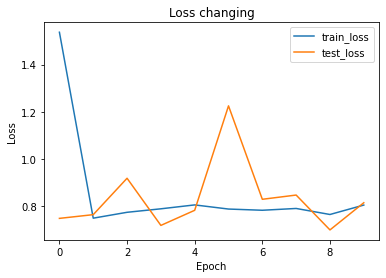

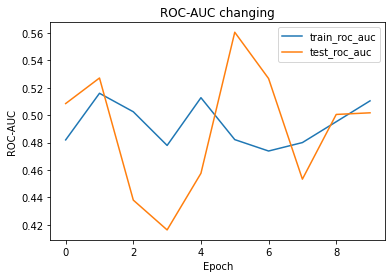

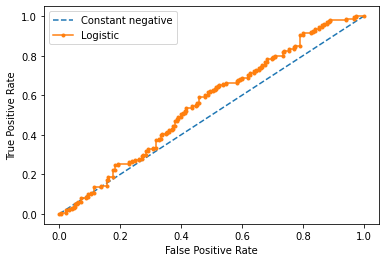

Total results for 7LayerCNN on A->B:

RMS: 3.507359027862549
Precision score: 0.0
Recall score: 0.0
Accuracy score: 0.5410764872521246
Balanced accuracy score: 0.4973958333333333
F1 score: 0.0
F1 weighted score: 0.3819363439426763
AUC-ROC score: 0.5606237060041407
CPU times: user 1d 3h 38min 46s, sys: 57min 26s, total: 1d 4h 36min 13s
Wall time: 2h 38min 43s


In [23]:
%%time
(model_AB2, metrics_AB2) = full_train_cycle(**train_config_AB2)

In [24]:
model_AB3 = CNN3()

train_config_AB3 = {
    "dataset_annotations_path": "/home/latna/aponom/whales/Canada/data/clips/dataset_A/train/annotations_A_train.csv",
    "dataset_files_path": "/home/latna/aponom/whales/Canada/data/clips/dataset_A/train/audio/",
    "dataset_name": "A->B",
    "model": model_AB3,
    "model_name": "3LayerCNN",
    "device": "cpu",
    "criterion": nn.BCEWithLogitsLoss(),
    "optimizer": optim.Adam(model_AB3.parameters(), lr=0.01),
    "epochs": 20,
    "full": True
}

A->B:

Train size = 1767
Test size = 353



  0%|          | 0/1767 [00:00<?, ?it/s]

Epoch: 1
Train Loss = 0.6858930587768555, Train ROC-AUC = 0.5322961666614112
Test Loss = 0.6876656413078308, Test ROC-AUC = 0.582718685300207
Model saved successfully



  0%|          | 0/1767 [00:00<?, ?it/s]

Epoch: 2
Train Loss = 0.6719282865524292, Train ROC-AUC = 0.58085932162415
Test Loss = 0.6759145259857178, Test ROC-AUC = 0.5970820393374741
Model saved successfully



  0%|          | 0/1767 [00:00<?, ?it/s]

Epoch: 3
Train Loss = 0.6603166460990906, Train ROC-AUC = 0.6269576619472561
Test Loss = 0.6832482814788818, Test ROC-AUC = 0.5907091097308489



  0%|          | 0/1767 [00:00<?, ?it/s]

Epoch: 4
Train Loss = 0.651473879814148, Train ROC-AUC = 0.6470217261060134
Test Loss = 0.6836484670639038, Test ROC-AUC = 0.6348343685300207
Model saved successfully



  0%|          | 0/1767 [00:00<?, ?it/s]

Epoch: 5
Train Loss = 0.6469349265098572, Train ROC-AUC = 0.6478665426376145
Test Loss = 0.6682073473930359, Test ROC-AUC = 0.626164596273292



  0%|          | 0/1767 [00:00<?, ?it/s]

Epoch: 6
Train Loss = 0.6489954590797424, Train ROC-AUC = 0.6442652329749103
Test Loss = 0.6539593935012817, Test ROC-AUC = 0.6575116459627329
Model saved successfully



  0%|          | 0/1767 [00:00<?, ?it/s]

Epoch: 7
Train Loss = 0.6420100927352905, Train ROC-AUC = 0.6627395179684462
Test Loss = 0.6717729568481445, Test ROC-AUC = 0.6170742753623188



  0%|          | 0/1767 [00:00<?, ?it/s]

Epoch: 8
Train Loss = 0.6400635838508606, Train ROC-AUC = 0.6663395137640715
Test Loss = 0.6622880697250366, Test ROC-AUC = 0.6642727743271222
Model saved successfully



  0%|          | 0/1767 [00:00<?, ?it/s]

Epoch: 9
Train Loss = 0.6376470923423767, Train ROC-AUC = 0.6746484091697411
Test Loss = 0.7155659794807434, Test ROC-AUC = 0.6431159420289855



  0%|          | 0/1767 [00:00<?, ?it/s]

Epoch: 10
Train Loss = 0.6255686283111572, Train ROC-AUC = 0.6937034234120603
Test Loss = 0.658547043800354, Test ROC-AUC = 0.6500711697722568



  0%|          | 0/1767 [00:00<?, ?it/s]

Epoch: 11
Train Loss = 0.6423286199569702, Train ROC-AUC = 0.6590882813567517
Test Loss = 0.6680790185928345, Test ROC-AUC = 0.6619435817805384



  0%|          | 0/1767 [00:00<?, ?it/s]

Epoch: 12
Train Loss = 0.6607032418251038, Train ROC-AUC = 0.6189811749124965
Test Loss = 0.6779592633247375, Test ROC-AUC = 0.5995729813664596



  0%|          | 0/1767 [00:00<?, ?it/s]

Epoch: 13
Train Loss = 0.6556313633918762, Train ROC-AUC = 0.6324601372728323
Test Loss = 0.68156898021698, Test ROC-AUC = 0.6051695134575569



  0%|          | 0/1767 [00:00<?, ?it/s]

Epoch: 14
Train Loss = 0.6540899276733398, Train ROC-AUC = 0.6375290364624392
Test Loss = 0.7038280367851257, Test ROC-AUC = 0.572366718426501



  0%|          | 0/1767 [00:00<?, ?it/s]

Epoch: 15
Train Loss = 0.658341109752655, Train ROC-AUC = 0.6232696370573582
Test Loss = 0.6631391644477844, Test ROC-AUC = 0.6304994824016563



  0%|          | 0/1767 [00:00<?, ?it/s]

Epoch: 16
Train Loss = 0.6506459712982178, Train ROC-AUC = 0.6533939814376859
Test Loss = 0.6735991835594177, Test ROC-AUC = 0.6293672360248448



  0%|          | 0/1767 [00:00<?, ?it/s]

Epoch: 17
Train Loss = 0.6479809880256653, Train ROC-AUC = 0.6498701899326249
Test Loss = 0.663093090057373, Test ROC-AUC = 0.6461244824016563



  0%|          | 0/1767 [00:00<?, ?it/s]

Epoch: 18
Train Loss = 0.6545742154121399, Train ROC-AUC = 0.6386405680110155
Test Loss = 0.6609389781951904, Test ROC-AUC = 0.6407867494824017



  0%|          | 0/1767 [00:00<?, ?it/s]

Epoch: 19
Train Loss = 0.6523886322975159, Train ROC-AUC = 0.6333936398322454
Test Loss = 0.6791654229164124, Test ROC-AUC = 0.5966938405797102



  0%|          | 0/1767 [00:00<?, ?it/s]

Epoch: 20
Train Loss = 0.6532559394836426, Train ROC-AUC = 0.6393645087713766
Test Loss = 0.6640602946281433, Test ROC-AUC = 0.6362577639751552



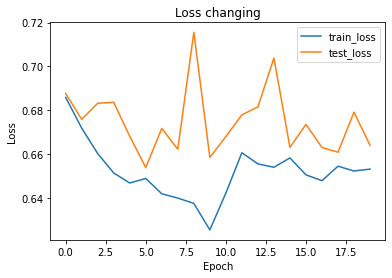

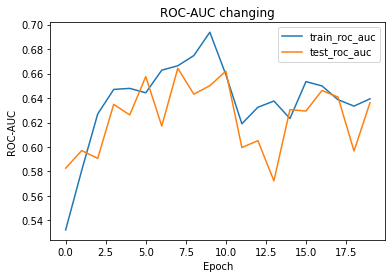

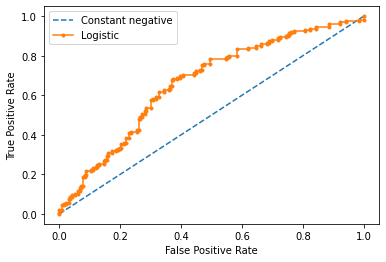

Total results for 3LayerCNN on A->B:

RMS: 0.7582423090934753
Precision score: 0.5824175824175825
Recall score: 0.32919254658385094
Accuracy score: 0.5864022662889519
Balanced accuracy score: 0.5656379399585921
F1 score: 0.42063492063492064
F1 weighted score: 0.5608434244480219
AUC-ROC score: 0.6642727743271222
CPU times: user 4h 48min 39s, sys: 2min 17s, total: 4h 50min 56s
Wall time: 25min 50s


In [25]:
%%time
(model_AB3, metrics_AB3) = full_train_cycle(**train_config_AB3)

In [69]:
WhalesDataset = AudioDataset(pd.read_csv("/home/latna/aponom/whales/Canada/data/clips/dataset_B/train/annotations_B_train.csv", sep=';'), 
                             "/home/latna/aponom/whales/Canada/data/clips/dataset_B/train/audio/")
test_predictions = torch.empty(0, device=device)
test_loader = DataLoader(WhalesDataset, shuffle=False)
test_labels = torch.empty(0, device=device)
with torch.no_grad():
    for data, label in tqdm(test_loader, total=len(test_loader)):
        data, label = data.to(device).float(), label.to(device).float()
        predictions = torch.as_tensor((0.5 * torch.as_tensor(model_AB3(data)[0]) + 0.3 * torch.as_tensor(model_AB2(data)[0])) + 0.2 * torch.as_tensor(model_AB1(data)[0]))
        test_predictions = torch.cat((test_predictions, predictions))
        test_labels = torch.cat((test_labels, label))
    test_predictions = torch.squeeze(test_predictions)
    test_labels = torch.squeeze(test_labels)

  0%|          | 0/3309 [00:00<?, ?it/s]

In [70]:
from xgboost import XGBRegressor

xgb_params = {
    'objective': 'binary:logistic', 
    'n_estimators': 750, 
    'scale_pos_weight': 9
}

xgb_model = XGBRegressor(**xgb_params)

In [71]:
test_labels = test_labels.cpu().detach().numpy()
test_predictions = test_predictions.cpu().detach().numpy()

xgb_indexes = list(range(0, len(test_labels)))

xgb_train_indexes = xgb_indexes[:round(0.8 * len(test_labels))]
xgb_test_indexes = xgb_indexes[round(0.8 * len(test_labels)):]

xgb_X_train = test_predictions[np.array(xgb_train_indexes)]
xgb_Y_train = test_labels[np.array(xgb_train_indexes)]
xgb_X_test = test_predictions[np.array(xgb_test_indexes)]
xgb_Y_test = test_labels[np.array(xgb_test_indexes)]

In [72]:
%%time
xgb_model.fit(np.array(xgb_X_train).reshape(-1, 1), np.array(xgb_Y_train).reshape(-1, 1))

[16:44:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 1min 48s, sys: 562 ms, total: 1min 49s
Wall time: 5.57 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=750, n_jobs=24, num_parallel_tree=1,
             objective='binary:logistic', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=9, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [73]:
preds = xgb_model.predict(np.array(xgb_X_test).reshape(-1, 1))
metrics_AB_xgb = getMetrics(np.array(xgb_Y_test), preds)

RMS: 0.569586992263794
Precision score: 0.6332737030411449
Recall score: 0.8655256723716381
Accuracy score: 0.6072507552870091
Balanced accuracy score: 0.5276244962648704
F1 score: 0.731404958677686
F1 weighted score: 0.5549385909370047
AUC-ROC score: 0.5166896991601998


In [88]:
threshold = find_best_threshold(np.array(xgb_Y_test), preds)[1]
metrics_AB_xgb_ = getMetrics(np.array(xgb_Y_test), preds, threshold=threshold)

RMS: 0.569586992263794
Precision score: 0.6390625
Recall score: 1.0
Accuracy score: 0.6510574018126888
Balanced accuracy score: 0.5434782608695652
F1 score: 0.7797902764537654
F1 weighted score: 0.5429217871141845
AUC-ROC score: 0.5166896991601998


---

### B->A

In [89]:
model_BA1 = CNN1()

train_config_BA1 = {
    "dataset_annotations_path": "/home/latna/aponom/whales/Canada/data/clips/dataset_B/train/annotations_B_train.csv",
    "dataset_files_path": "/home/latna/aponom/whales/Canada/data/clips/dataset_B/train/audio/",
    "dataset_name": "B->A",
    "model": model_BA1,
    "model_name": "5LayerCNN",
    "device": "cpu",
    "criterion": nn.BCEWithLogitsLoss(),
    "optimizer": optim.Adam(model_BA1.parameters(), lr=0.01),
    "epochs": 10,
    "full": True
}

B->A:

Train size = 3309
Test size = 662



  0%|          | 0/3309 [00:00<?, ?it/s]

Epoch: 1
Train Loss = 0.741080105304718, Train ROC-AUC = 0.510728928787853
Test Loss = 0.6692606806755066, Test ROC-AUC = 0.5016090532195561
Model saved successfully



  0%|          | 0/3309 [00:00<?, ?it/s]

Epoch: 2
Train Loss = 0.6778206825256348, Train ROC-AUC = 0.5098241861942525
Test Loss = 0.6917887926101685, Test ROC-AUC = 0.5157764527382896
Model saved successfully



  0%|          | 0/3309 [00:00<?, ?it/s]

Epoch: 3
Train Loss = 0.6840916872024536, Train ROC-AUC = 0.502916609485804
Test Loss = 0.6677350401878357, Test ROC-AUC = 0.5190815350271074
Model saved successfully



  0%|          | 0/3309 [00:00<?, ?it/s]

Epoch: 4
Train Loss = 0.6843246221542358, Train ROC-AUC = 0.506931091535125
Test Loss = 0.6691935658454895, Test ROC-AUC = 0.5596219449732791
Model saved successfully



  0%|          | 0/3309 [00:00<?, ?it/s]

Epoch: 5
Train Loss = 0.6855142116546631, Train ROC-AUC = 0.49972630283704456
Test Loss = 0.6836901903152466, Test ROC-AUC = 0.4990094417116847



  0%|          | 0/3309 [00:00<?, ?it/s]

Epoch: 6
Train Loss = 0.6847390532493591, Train ROC-AUC = 0.4996943072532061
Test Loss = 0.69492506980896, Test ROC-AUC = 0.4443982720797859



  0%|          | 0/3309 [00:00<?, ?it/s]

Epoch: 7
Train Loss = 0.6822746992111206, Train ROC-AUC = 0.48674342008890914
Test Loss = 0.6699620485305786, Test ROC-AUC = 0.4715444011712747



  0%|          | 0/3309 [00:00<?, ?it/s]

Epoch: 8
Train Loss = 0.6822766065597534, Train ROC-AUC = 0.49153312044062925
Test Loss = 0.6661034226417542, Test ROC-AUC = 0.49688336538554456



  0%|          | 0/3309 [00:00<?, ?it/s]

Epoch: 9
Train Loss = 0.6853939890861511, Train ROC-AUC = 0.5008534725616667
Test Loss = 0.6640737056732178, Test ROC-AUC = 0.5279530716970922



  0%|          | 0/3309 [00:00<?, ?it/s]

Epoch: 10
Train Loss = 0.6847232580184937, Train ROC-AUC = 0.5082591010089017
Test Loss = 0.6690771579742432, Test ROC-AUC = 0.47925625984518305



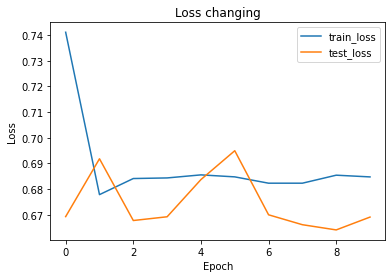

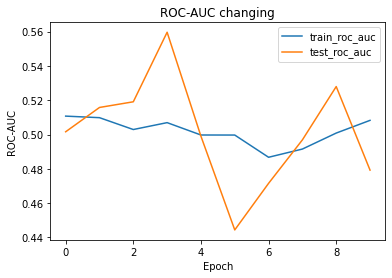

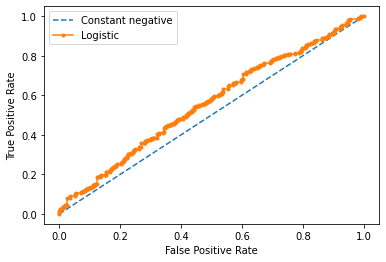

Total results for 5LayerCNN on B->A:

RMS: 0.6479002833366394
Precision score: 0.8235294117647058
Recall score: 0.034229828850855744
Accuracy score: 0.3987915407854985
Balanced accuracy score: 0.5111860606704871
F1 score: 0.06572769953051642
F1 weighted score: 0.2534006434893371
AUC-ROC score: 0.5596219449732791
CPU times: user 1d 14h 13min 15s, sys: 30min 33s, total: 1d 14h 43min 49s
Wall time: 2h 6min 50s


In [90]:
%%time
(model_BA1, metrics_BA1) = full_train_cycle(**train_config_BA1)

In [96]:
model_BA2 = CNN2()

train_config_BA2 = {
    "dataset_annotations_path": "/home/latna/aponom/whales/Canada/data/clips/dataset_B/train/annotations_B_train.csv",
    "dataset_files_path": "/home/latna/aponom/whales/Canada/data/clips/dataset_B/train/audio/",
    "dataset_name": "B->A",
    "model": model_BA2,
    "model_name": "7LayerCNN",
    "device": "cpu",
    "criterion": nn.BCEWithLogitsLoss(),
    "optimizer": optim.Adam(model_BA2.parameters(), lr=0.01),
    "epochs": 4,
    "full": True
}

B->A:

Train size = 3309
Test size = 662



  0%|          | 0/3309 [00:00<?, ?it/s]

Epoch: 1
Train Loss = 1.2529797554016113, Train ROC-AUC = 0.4880209305086758
Test Loss = 0.6805652379989624, Test ROC-AUC = 0.5172647061665877
Model saved successfully



  0%|          | 0/3309 [00:00<?, ?it/s]

Epoch: 2
Train Loss = 0.7730342745780945, Train ROC-AUC = 0.513297827230015
Test Loss = 0.7694897055625916, Test ROC-AUC = 0.5064700368197763



  0%|          | 0/3309 [00:00<?, ?it/s]

Epoch: 3
Train Loss = 0.7882354259490967, Train ROC-AUC = 0.5058910423158943
Test Loss = 0.7338384389877319, Test ROC-AUC = 0.5013771176203408



  0%|          | 0/3309 [00:00<?, ?it/s]

Epoch: 4
Train Loss = 0.7858572602272034, Train ROC-AUC = 0.48621530021109377
Test Loss = 0.7151534557342529, Test ROC-AUC = 0.4972795887008707



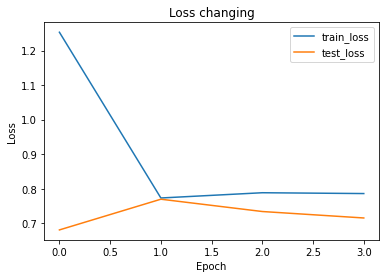

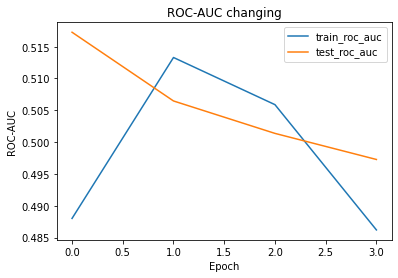

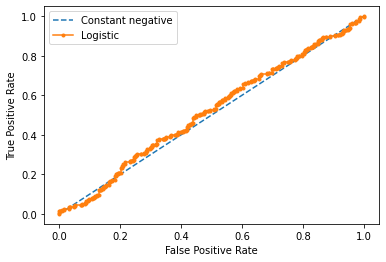

Total results for 7LayerCNN on B->A:

RMS: 0.6866350769996643
Precision score: 0.594059405940594
Recall score: 0.1466992665036675
Accuracy score: 0.4108761329305136
Balanced accuracy score: 0.49232196526764405
F1 score: 0.23529411764705885
F1 weighted score: 0.34443969471515234
AUC-ROC score: 0.5172647061665877
CPU times: user 2d 16min 2s, sys: 45min 25s, total: 2d 1h 1min 27s
Wall time: 2h 41min 58s


In [97]:
%%time
(model_BA2, metrics_BA2) = full_train_cycle(**train_config_BA2)

In [93]:
model_BA3 = CNN3()

train_config_BA3 = {
    "dataset_annotations_path": "/home/latna/aponom/whales/Canada/data/clips/dataset_B/train/annotations_B_train.csv",
    "dataset_files_path": "/home/latna/aponom/whales/Canada/data/clips/dataset_B/train/audio/",
    "dataset_name": "B->A",
    "model": model_BA3,
    "model_name": "3LayerCNN",
    "device": "cpu",
    "criterion": nn.BCEWithLogitsLoss(),
    "optimizer": optim.Adam(model_BA3.parameters(), lr=0.01),
    "epochs": 15
}

B->A:

Train size = 2647
Test size = 662



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 1
Train Loss = 0.6732050180435181, Train ROC-AUC = 0.490606445834477
Test Loss = 0.6653931140899658, Test ROC-AUC = 0.5171873943001826
Model saved successfully



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 2
Train Loss = 0.6694907546043396, Train ROC-AUC = 0.48255878344866104
Test Loss = 0.6652798652648926, Test ROC-AUC = 0.47747808691786586



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 3
Train Loss = 0.6688679456710815, Train ROC-AUC = 0.4892415935936515
Test Loss = 0.6653304696083069, Test ROC-AUC = 0.48034828995815493



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 4
Train Loss = 0.6686175465583801, Train ROC-AUC = 0.4964522870529545
Test Loss = 0.6689783930778503, Test ROC-AUC = 0.5431351894623926
Model saved successfully



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 5
Train Loss = 0.6689188480377197, Train ROC-AUC = 0.5085761476195292
Test Loss = 0.666100263595581, Test ROC-AUC = 0.4930177720652899



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 6
Train Loss = 0.6710231900215149, Train ROC-AUC = 0.4970632352445478
Test Loss = 0.6691107749938965, Test ROC-AUC = 0.5247639572078819



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 7
Train Loss = 0.6704843044281006, Train ROC-AUC = 0.509115467402453
Test Loss = 0.6680008172988892, Test ROC-AUC = 0.5071948355673241



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 8
Train Loss = 0.668204128742218, Train ROC-AUC = 0.5130339627002587
Test Loss = 0.6675446629524231, Test ROC-AUC = 0.48402060361239696



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 9
Train Loss = 0.6691208481788635, Train ROC-AUC = 0.5254822578237484
Test Loss = 0.6646392345428467, Test ROC-AUC = 0.5094368796930718



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 10
Train Loss = 0.6678058505058289, Train ROC-AUC = 0.49948295123489783
Test Loss = 0.6612432599067688, Test ROC-AUC = 0.5390956444427264



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 11
Train Loss = 0.66728675365448, Train ROC-AUC = 0.5155800817647314
Test Loss = 0.6609906554222107, Test ROC-AUC = 0.5407481855871352



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 12
Train Loss = 0.6654917001724243, Train ROC-AUC = 0.5226020734919511
Test Loss = 0.6564623117446899, Test ROC-AUC = 0.5471457425321569
Model saved successfully



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 13
Train Loss = 0.6601398587226868, Train ROC-AUC = 0.5531217947791919
Test Loss = 0.6516140699386597, Test ROC-AUC = 0.5730935376943669
Model saved successfully



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 14
Train Loss = 0.6662358045578003, Train ROC-AUC = 0.5299978571669339
Test Loss = 0.6644030213356018, Test ROC-AUC = 0.5536882592266881



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 15
Train Loss = 0.6651198863983154, Train ROC-AUC = 0.5405519119367841
Test Loss = 0.663955807685852, Test ROC-AUC = 0.5351817312059685



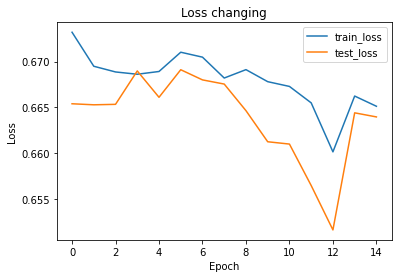

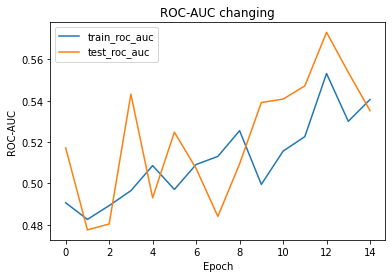

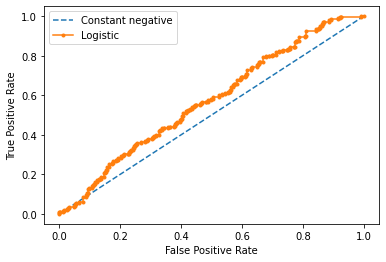

Total results for 3LayerCNN on B->A:

RMS: 0.4927833378314972
Precision score: 0.6440071556350626
Recall score: 0.8801955990220048
Accuracy score: 0.6253776435045317
Balanced accuracy score: 0.5468171670999352
F1 score: 0.743801652892562
F1 weighted score: 0.5754798867399122
AUC-ROC score: 0.5730935376943669
CPU times: user 1d 5h 31min 48s, sys: 19min 2s, total: 1d 5h 50min 50s
Wall time: 1h 34min 6s


In [94]:
%%time
(model_BA3, metrics_BA3) = full_train_cycle(**train_config_BA3)

In [98]:
WhalesDataset = AudioDataset(pd.read_csv("/home/latna/aponom/whales/Canada/data/clips/dataset_A/train/annotations_A_train.csv", sep=';'), 
                             "/home/latna/aponom/whales/Canada/data/clips/dataset_A/train/audio/")
test_loader = DataLoader(WhalesDataset, shuffle=False)
test_predictions = torch.empty(0, device=device)
test_labels = torch.empty(0, device=device)
with torch.no_grad():
    for data, label in tqdm(test_loader, total=len(test_loader)):
        data, label = data.to(device).float(), label.to(device).float()
        predictions = torch.as_tensor((0.5 * torch.as_tensor(model_BA3(data)[0]) + 0.3 * torch.as_tensor(model_BA2(data)[0]) + 0.2 * torch.as_tensor(model_BA1(data)[0])))
        test_predictions = torch.cat((test_predictions, predictions))
        test_labels = torch.cat((test_labels, label))
    test_predictions = torch.squeeze(test_predictions)
    test_labels = torch.squeeze(test_labels)

  0%|          | 0/1767 [00:00<?, ?it/s]

In [99]:
xgb_params = {
    'objective': 'binary:logistic', 
    'n_estimators': 750, 
    'scale_pos_weight': 9
}

xgb_model = XGBRegressor(**xgb_params)

In [100]:
xgb_indexes = list(range(0, len(test_labels)))

xgb_train_indexes = xgb_indexes[:round(0.8 * len(test_labels))]
xgb_test_indexes = xgb_indexes[round(0.8 * len(test_labels)):]

xgb_X_train = test_predictions[np.array(xgb_train_indexes)]
xgb_Y_train = test_labels[np.array(xgb_train_indexes)]
xgb_X_test = test_predictions[np.array(xgb_test_indexes)]
xgb_Y_test = test_labels[np.array(xgb_test_indexes)]

In [101]:
%%time
xgb_model.fit(np.array(xgb_X_train).reshape(-1, 1), np.array(xgb_Y_train).reshape(-1, 1))

[23:21:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 1min 18s, sys: 472 ms, total: 1min 18s
Wall time: 4.28 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=750, n_jobs=24, num_parallel_tree=1,
             objective='binary:logistic', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=9, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [102]:
preds = xgb_model.predict(np.array(xgb_X_test).reshape(-1, 1))
metrics_BA_xgb = getMetrics(np.array(xgb_Y_test), preds)

RMS: 0.608325719833374
Precision score: 0.4926829268292683
Recall score: 0.6273291925465838
Accuracy score: 0.5354107648725213
Balanced accuracy score: 0.5428312629399585
F1 score: 0.5519125683060109
F1 weighted score: 0.5332752373693637
AUC-ROC score: 0.5675951086956523


In [103]:
threshold = find_best_threshold(np.array(xgb_Y_test), preds)[1]
metrics_BA_xgb_ = getMetrics(np.array(xgb_Y_test), preds, threshold=threshold)

RMS: 0.608325719833374
Precision score: 0.5050847457627119
Recall score: 0.9254658385093167
Accuracy score: 0.5524079320113314
Balanced accuracy score: 0.582524585921325
F1 score: 0.6535087719298246
F1 weighted score: 0.49821788181501914
AUC-ROC score: 0.5675951086956523


|                 |A->A               |B->B               |A->B               |B->A               |
|:---------------:|:------------------|:-----------------:|:-----------------:|:-----------------:|
|ROC-AUC          |0.9243             |0.5260             |0.5167             |0.5676             |
|F1-score         |0.8250             |0.7828             |0.7798             |0.6535             |
|Precision        |0.7404             |0.6339             |0.6390             |0.5051             |
|Recall           |0.9315             |1.0                |1.0                |0.92             |